In [2]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization.pulse_v2 import draw
from utils import plot_shot_results, get_closest_multiple_of_16, save_value, load_value, load_Signal
from optimal_control import OptimalControl

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


In [4]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [5]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [6]:
backend_defaults = backend.defaults()

In [7]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.971657042036229 GHz.


In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [9]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [10]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [11]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [12]:
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating 

print('The length of the gaussian pulse is',drive_samples)

The length of the gaussian pulse is 2704


In [13]:
def plot_shot_results(job):
    from matplotlib import pyplot as plt
    y_pulse_results = job.result(timeout=120)
    measure_list = y_pulse_results.get_counts()
    zero_list = []
    sum_list = []
    print(measure_list)
    for prob in measure_list:
        s = 0.
        for x in prob:
            s+=prob[x]
        sum_list.append(s)
        try:
            zero_list.append(prob['1'])
        except:
            zero_list.append(0)
    print(zero_list)
    plt.plot(sum_list)
    plt.plot(zero_list, '.')
    plt.show()

In [14]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

## 1. Define Qiskit default Clifford gate (In the schedule form)

In [15]:
from qiskit import QuantumCircuit
from qiskit import transpile, schedule as build_schedule

%matplotlib inline
x_circ = QuantumCircuit(1, 1)
x_circ.x(0)
x_circ = transpile(x_circ, backend)
x_schedule = build_schedule(x_circ, backend)

y_circ = QuantumCircuit(1, 1)
y_circ.y(0)
y_circ = transpile(y_circ, backend)
y_schedule = build_schedule(y_circ, backend)

z_circ = QuantumCircuit(1, 1)
z_circ.z(0)
z_circ = transpile(z_circ, backend)
z_schedule = build_schedule(z_circ, backend)

s_circ = QuantumCircuit(1, 1)
s_circ.s(0)
s_circ = transpile(s_circ, backend)
s_schedule = build_schedule(s_circ, backend)


xs_circ = QuantumCircuit(1, 1)
xs_circ.s(0)
xs_circ.x(0)
xs_circ = transpile(xs_circ, backend)
xs_schedule = build_schedule(xs_circ, backend)

ys_circ = QuantumCircuit(1, 1)
ys_circ.s(0)
ys_circ.y(0)
ys_circ = transpile(ys_circ, backend)
ys_schedule = build_schedule(ys_circ, backend)

zs_circ = QuantumCircuit(1, 1)
zs_circ.s(0)
zs_circ.z(0)
zs_circ = transpile(zs_circ, backend)
zs_schedule = build_schedule(zs_circ, backend)

h_circ = QuantumCircuit(1, 1)
h_circ.h(0)
backend = backend
h_circ = transpile(h_circ, backend)
h_schedule = build_schedule(h_circ, backend)

xh_circ = QuantumCircuit(1, 1)
xh_circ.h(0)
xh_circ.x(0)
backend = backend
xh_circ = transpile(xh_circ, backend)
xh_schedule = build_schedule(xh_circ, backend)

yh_circ = QuantumCircuit(1, 1)
yh_circ.h(0)
yh_circ.y(0)
yh_circ = transpile(yh_circ, backend)
yh_schedule = build_schedule(yh_circ, backend)

zh_circ = QuantumCircuit(1, 1)
zh_circ.h(0)
zh_circ.z(0)
zh_circ = transpile(zh_circ, backend)
zh_schedule = build_schedule(zh_circ, backend)

sh_circ = QuantumCircuit(1, 1)
sh_circ.h(0)
sh_circ.s(0)
sh_circ = transpile(sh_circ, backend)
sh_schedule = build_schedule(sh_circ, backend)

xsh_circ = QuantumCircuit(1, 1)
xsh_circ.h(0)
xsh_circ.s(0)
xsh_circ.x(0)
xsh_circ = transpile(xsh_circ, backend)
xsh_schedule = build_schedule(xsh_circ, backend)

ysh_circ = QuantumCircuit(1, 1)
ysh_circ.h(0)
ysh_circ.s(0)
ysh_circ.y(0)
ysh_circ = transpile(ysh_circ, backend)
ysh_schedule = build_schedule(ysh_circ, backend)

zsh_circ = QuantumCircuit(1, 1)
zsh_circ.h(0)
zsh_circ.s(0)
zsh_circ.z(0)
zsh_circ = transpile(zsh_circ, backend)
zsh_schedule = build_schedule(zsh_circ, backend)

hs_circ = QuantumCircuit(1, 1)
hs_circ.s(0)
hs_circ.h(0)
hs_circ = transpile(hs_circ, backend)
hs_schedule = build_schedule(hs_circ, backend)

xhs_circ = QuantumCircuit(1, 1)
xhs_circ.s(0)
xhs_circ.h(0)
xhs_circ.x(0)
xhs_circ = transpile(xhs_circ, backend)
xhs_schedule = build_schedule(xhs_circ, backend)

yhs_circ = QuantumCircuit(1, 1)
yhs_circ.s(0)
yhs_circ.h(0)
yhs_circ.y(0)
yhs_circ = transpile(yhs_circ, backend)
yhs_schedule = build_schedule(yhs_circ, backend)

zhs_circ = QuantumCircuit(1, 1)
zhs_circ.s(0)
zhs_circ.h(0)
zhs_circ.z(0)
zhs_circ = transpile(zhs_circ, backend)
zhs_schedule = build_schedule(zhs_circ, backend)

shs_circ = QuantumCircuit(1, 1)
shs_circ.s(0)
shs_circ.h(0)
shs_circ.s(0)
shs_circ = transpile(shs_circ, backend)
shs_schedule = build_schedule(shs_circ, backend)

xshs_circ = QuantumCircuit(1, 1)
xshs_circ.s(0)
xshs_circ.h(0)
xshs_circ.s(0)
xshs_circ.x(0)
xshs_circ = transpile(xshs_circ, backend)
xshs_schedule = build_schedule(xshs_circ, backend)

yshs_circ = QuantumCircuit(1, 1)
yshs_circ.s(0)
yshs_circ.h(0)
yshs_circ.s(0)
yshs_circ.y(0)
yshs_circ = transpile(yshs_circ, backend)
yshs_schedule = build_schedule(yshs_circ, backend)

zshs_circ = QuantumCircuit(1, 1)
zshs_circ.s(0)
zshs_circ.h(0)
zshs_circ.s(0)
zshs_circ.z(0)
zshs_circ = transpile(zshs_circ, backend)
zshs_schedule = build_schedule(zshs_circ, backend)


In [16]:
qiskit_clifford_schedules = [
0,\
x_schedule,\
y_schedule,\
z_schedule,\
s_schedule,\
xs_schedule,\
ys_schedule,\
zs_schedule,\
h_schedule,\
xh_schedule,\
yh_schedule,\
zh_schedule,\
sh_schedule,\
xsh_schedule,\
ysh_schedule,\
zsh_schedule,\
hs_schedule,\
xhs_schedule,\
yhs_schedule,\
zhs_schedule,\
shs_schedule,\
xshs_schedule,\
yshs_schedule,\
zshs_schedule,\
]

# 2. Define Gaussian Clifford Gates

In [17]:
pi_amp = 0.1338881278135786
x_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='x_pi_pulse')
x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_halfpi_pulse')
minus_x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_minus_halfpi_pulse')
y_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp *1j, 
                              sigma=drive_sigma,
                              name='y_pi_pulse')
y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_halfpi_pulse')
minus_y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_minus_halfpi_pulse')

## Our gaussian clifford gates !

In [21]:
x_pulse = pulse.Waveform(x_pi_pulse.samples, name = 'x')
y_pulse = pulse.Waveform(y_pi_pulse.samples, name = 'y')
z_pulse_samples = np.concatenate((x_pi_pulse.samples, y_pi_pulse.samples))
z_pulse = pulse.Waveform(z_pulse_samples, name = 'z')
s_pulse_samples = np.concatenate((y_halfpi_pulse.samples,x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
s_pulse = pulse.Waveform(s_pulse_samples, name = 's')
xs_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples))
xs_pulse = pulse.Waveform(xs_pulse_samples, name = 'xs')
ys_pulse_samples = np.concatenate((minus_y_halfpi_pulse.samples,minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
ys_pulse = pulse.Waveform(ys_pulse_samples, name = 'ys')
zs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
zs_pulse = pulse.Waveform(zs_pulse_samples, name = 'zs')
h_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_pi_pulse.samples)), name = 'h')
xh_pulse = pulse.Waveform(y_halfpi_pulse.samples, name = 'xh')
yh_pulse = pulse.Waveform(np.concatenate((x_pi_pulse.samples, y_halfpi_pulse.samples)), name = 'yh')
zh_pulse = pulse.Waveform(minus_y_halfpi_pulse.samples, name = 'zh')
sh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples)), name = 'sh')
xsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,minus_y_halfpi_pulse.samples, x_pi_pulse.samples))
xsh_pulse = pulse.Waveform(xsh_pulse_samples, name = 'xsh')
ysh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples)), name = 'ysh')
zsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples, x_pi_pulse.samples))
zsh_pulse = pulse.Waveform(zsh_pulse_samples, name = 'zsh')
hs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples)), name = 'hs')
xhs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples)), name = 'xhs')
yhs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, y_pi_pulse.samples))
yhs_pulse = pulse.Waveform(yhs_pulse_samples, name = 'yhs')
zhs_pulse_samples =  np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples, y_pi_pulse.samples))
zhs_pulse = pulse.Waveform(zhs_pulse_samples, name= 'zhs')
shs_pulse = pulse.Waveform(minus_x_halfpi_pulse.samples, name= 'shs')
xshs_pulse = pulse.Waveform(x_halfpi_pulse.samples, name= 'xshs')
yshs_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'yshs')
zshs_pulse = pulse.Waveform(np.concatenate((x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'zshs')

In [22]:
from qiskit.pulse import ShiftPhase
G_x_schedule = Play(x_pulse, drive_chan)
G_y_schedule = Play(y_pulse, drive_chan)
G_z_schedule = z_schedule

G_s_schedule = s_schedule
G_xs_schedule = G_s_schedule + G_x_schedule
G_ys_schedule = G_s_schedule + G_y_schedule
G_zs_schedule = G_s_schedule + G_z_schedule

G_h_schedule = G_z_schedule + Play(y_halfpi_pulse, drive_chan)
G_xh_schedule = Play(y_halfpi_pulse, drive_chan)
G_yh_schedule = G_z_schedule + Play(minus_y_halfpi_pulse, drive_chan)
G_zh_schedule = Play(minus_y_halfpi_pulse, drive_chan)

G_sh_schedule = Play(minus_y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
G_xsh_schedule = Play(y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
G_ysh_schedule = Play(y_halfpi_pulse, drive_chan) + G_s_schedule
G_zsh_schedule = Play(minus_y_halfpi_pulse, drive_chan) + G_s_schedule

G_hs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(y_halfpi_pulse, drive_chan)
G_xhs_schedule = G_s_schedule + Play(y_halfpi_pulse, drive_chan)
G_yhs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(minus_y_halfpi_pulse, drive_chan)
G_zhs_schedule = G_s_schedule + Play(minus_y_halfpi_pulse, drive_chan)

G_shs_schedule = Play(minus_x_halfpi_pulse, drive_chan)
G_xshs_schedule = Play(x_halfpi_pulse, drive_chan)
G_yshs_schedule = G_z_schedule + Play(minus_x_halfpi_pulse, drive_chan)
G_zshs_schedule = Play(minus_x_halfpi_pulse, drive_chan) + G_z_schedule

In [23]:
gaussian_clifford_gates = [
0,\
x_pulse,\
y_pulse,\
z_pulse,\
s_pulse,\
xs_pulse,\
ys_pulse,\
zs_pulse,\
h_pulse,\
xh_pulse,\
yh_pulse,\
zh_pulse,\
sh_pulse,\
xsh_pulse,\
ysh_pulse,\
zsh_pulse,\
hs_pulse,\
xhs_pulse,\
yhs_pulse,\
zhs_pulse,\
shs_pulse,\
xshs_pulse,\
yshs_pulse,\
zshs_pulse,\
]


In [24]:
gaussian_clifford_schedules = [
0,\
G_x_schedule,\
G_y_schedule,\
G_z_schedule,\
G_s_schedule,\
G_xs_schedule,\
G_ys_schedule,\
G_zs_schedule,\
G_h_schedule,\
G_xh_schedule,\
G_yh_schedule,\
G_zh_schedule,\
G_sh_schedule,\
G_xsh_schedule,\
G_ysh_schedule,\
G_zsh_schedule,\
G_hs_schedule,\
G_xhs_schedule,\
G_yhs_schedule,\
G_zhs_schedule,\
G_shs_schedule,\
G_xshs_schedule,\
G_yshs_schedule,\
G_zshs_schedule,\
]

# 3. Define SOC Clifford Gates

In [25]:
convert_factor = 1.64694154415136e-08,
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

amplitude_pi_X_x = np.loadtxt("./amplitudes/ours/amplitude_pi_X_x.csv", delimiter = ',') * convert_factor
amplitude_pi_X_y = np.loadtxt("./amplitudes/ours/amplitude_pi_X_y.csv", delimiter = ',') * convert_factor
Signal = np.zeros(drive_samples, np.complex128)


for i in range(len(amplitude_pi_X_x)):
    Signal += amplitude_pi_X_x[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1))
    Signal += amplitude_pi_X_y[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1)) * 1j
print(max(Signal))

(0.25230838251875964-0.004076602062011545j)


In [26]:
amplitude_multiplier = 1
SOC_x_pi_pulse = pulse.Waveform(Signal*amplitude_multiplier, name = 'SOC_x_pi_pulse')
SOC_y_pi_pulse = pulse.Waveform(Signal*amplitude_multiplier*1j, name = 'SOC_y_pi_pulse')

In [27]:
convert_factor = 1.64694154415136e-08
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

amplitude_pi_over_2_X_x = np.loadtxt("./amplitudes/ours/amplitude_pi_over_2_X_x.csv", delimiter = ',') * convert_factor
amplitude_pi_over_2_X_y = np.loadtxt("./amplitudes/ours/amplitude_pi_over_2_X_y.csv", delimiter = ',') * convert_factor
Signal = np.zeros(drive_samples, np.complex128)


for i in range(len(amplitude_pi_over_2_X_x)):
    Signal += amplitude_pi_over_2_X_x[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1))
    Signal += amplitude_pi_over_2_X_y[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1)) * 1j

In [28]:
amplitude_multiplier = 1
SOC_x_halfpi_pulse = pulse.Waveform(Signal*amplitude_multiplier, name = 'SOC_x_halfpi_pulse')
SOC_minus_x_halfpi_pulse = pulse.Waveform(-Signal*amplitude_multiplier, name = 'SOC_x_halfpi_pulse')
SOC_y_halfpi_pulse = pulse.Waveform(Signal*amplitude_multiplier*1j, name = 'SOC_y_halfpi_pulse')
SOC_minus_y_halfpi_pulse = pulse.Waveform(-Signal*amplitude_multiplier*1j, name = 'SOC_y_halfpi_pulse')

## OUR SOC Clifford Gates!

In [29]:
SOC_x_pulse = pulse.Waveform(SOC_x_pi_pulse.samples, name = 'SOC_x')
SOC_y_pulse = pulse.Waveform(SOC_y_pi_pulse.samples, name = 'SOC_y')
SOC_z_pulse_samples = np.concatenate((SOC_x_pi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_z_pulse = pulse.Waveform(SOC_z_pulse_samples, name = 'SOC_z')
SOC_s_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples,SOC_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_s_pulse = pulse.Waveform(SOC_s_pulse_samples, name = 'SOC_s')
SOC_xs_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples))
SOC_xs_pulse = pulse.Waveform(SOC_xs_pulse_samples, name = 'SOC_xs')
SOC_ys_pulse_samples = np.concatenate((SOC_minus_y_halfpi_pulse.samples,SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_ys_pulse = pulse.Waveform(SOC_ys_pulse_samples, name = 'SOC_ys')
SOC_zs_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_zs_pulse = pulse.Waveform(SOC_zs_pulse_samples, name = 'SOC_zs')
SOC_h_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_h_pulse = pulse.Waveform(SOC_h_pulse_samples, name = 'SOC_h')
SOC_xh_pulse = pulse.Waveform(SOC_y_halfpi_pulse.samples, name = 'SOC_xh')
SOC_yh_pulse = pulse.Waveform(np.concatenate((SOC_x_pi_pulse.samples, SOC_y_halfpi_pulse.samples)), name = 'SOC_yh')
SOC_zh_pulse = pulse.Waveform(SOC_minus_y_halfpi_pulse.samples, name = 'SOC_zh')
SOC_sh_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples)), name = 'SOC_sh')
SOC_xsh_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples,SOC_minus_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_xsh_pulse = pulse.Waveform(SOC_xsh_pulse_samples, name = 'xsh')
SOC_ysh_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples)), name = 'SOC_ysh')
SOC_zsh_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_zsh_pulse = pulse.Waveform(SOC_zsh_pulse_samples, name = 'SOC_zsh')
SOC_hs_pulse = pulse.Waveform(np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples)), name = 'SOC_hs')
SOC_xhs_pulse = pulse.Waveform(np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_halfpi_pulse.samples)), name = 'SOC_xhs')
SOC_yhs_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_yhs_pulse = pulse.Waveform(SOC_yhs_pulse_samples, name = 'SOC_yhs')
SOC_zhs_pulse_samples =  np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_zhs_pulse = pulse.Waveform(SOC_zhs_pulse_samples, name= 'SOC_zhs')
SOC_shs_pulse = pulse.Waveform(SOC_minus_x_halfpi_pulse.samples, name= 'SOC_shs')
SOC_xshs_pulse = pulse.Waveform(SOC_x_halfpi_pulse.samples, name= 'SOC_xshs')
SOC_yshs_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples)), name = 'SOC_yshs')
SOC_zshs_pulse = pulse.Waveform(np.concatenate((SOC_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples)), name = 'SOC_zshs')

In [33]:
S_x_schedule = Play(SOC_x_pi_pulse, drive_chan)
S_y_schedule = Play(SOC_y_pi_pulse, drive_chan)
S_z_schedule = z_schedule
S_s_schedule = s_schedule
S_xs_schedule = S_s_schedule + S_x_schedule
S_ys_schedule = S_s_schedule + S_y_schedule
S_zs_schedule = S_s_schedule + S_z_schedule
S_h_schedule = S_z_schedule + Play(SOC_y_halfpi_pulse, drive_chan)
S_xh_schedule = Play(SOC_y_halfpi_pulse, drive_chan)
S_yh_schedule = S_z_schedule + Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_zh_schedule = Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_sh_schedule = Play(SOC_minus_y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
S_xsh_schedule = Play(SOC_y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
S_ysh_schedule = Play(SOC_y_halfpi_pulse, drive_chan) + S_s_schedule
S_zsh_schedule = Play(SOC_minus_y_halfpi_pulse, drive_chan) + S_s_schedule
S_hs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(SOC_y_halfpi_pulse, drive_chan)
S_xhs_schedule = S_s_schedule + Play(SOC_y_halfpi_pulse, drive_chan)
S_yhs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_zhs_schedule = S_s_schedule + Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_shs_schedule = Play(SOC_minus_x_halfpi_pulse, drive_chan)
S_xshs_schedule = Play(SOC_x_halfpi_pulse, drive_chan)
S_yshs_schedule = S_z_schedule + Play(SOC_minus_x_halfpi_pulse, drive_chan)
S_zshs_schedule = Play(SOC_minus_x_halfpi_pulse, drive_chan) + S_z_schedule

In [34]:
SOC_clifford_gates = [
0,\
SOC_x_pulse,\
SOC_y_pulse,\
SOC_z_pulse,\
SOC_s_pulse,\
SOC_xs_pulse,\
SOC_ys_pulse,\
SOC_zs_pulse,\
SOC_h_pulse,\
SOC_xh_pulse,\
SOC_yh_pulse,\
SOC_zh_pulse,\
SOC_sh_pulse,\
SOC_xsh_pulse,\
SOC_ysh_pulse,\
SOC_zsh_pulse,\
SOC_hs_pulse,\
SOC_xhs_pulse,\
SOC_yhs_pulse,\
SOC_zhs_pulse,\
SOC_shs_pulse,\
SOC_xshs_pulse,\
SOC_yshs_pulse,\
SOC_zshs_pulse,\
]


In [35]:
SOC_clifford_schedules = [
0,\
S_x_schedule,\
S_y_schedule,\
S_z_schedule,\
S_s_schedule,\
S_xs_schedule,\
S_ys_schedule,\
S_zs_schedule,\
S_h_schedule,\
S_xh_schedule,\
S_yh_schedule,\
S_zh_schedule,\
S_sh_schedule,\
S_xsh_schedule,\
S_ysh_schedule,\
S_zsh_schedule,\
S_hs_schedule,\
S_xhs_schedule,\
S_yhs_schedule,\
S_zhs_schedule,\
S_shs_schedule,\
S_xshs_schedule,\
S_yshs_schedule,\
S_zshs_schedule,\
]

# 3-2 Paper SOC

In [36]:
convert_factor = load_value('convert_factor')
drive_samples = int(500e-9/dt)
omega = np.pi/(500*1e-9)
#delete below code
drive_samples = get_closest_multiple_of_16(drive_samples)

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/paper/amplitude_pi_X_x.csv", "amplitudes/paper/amplitude_pi_X_y.csv")
Signal *= 1e6 * convert_factor
amplitude_detuning_array = np.linspace(3.,8, 50)

In [37]:
amplitude_multiplier_paper_SOC = load_value('amplitude_multiplier_paper_SOC')
angle = load_value('paper_SOC_pi_angle')

Signal_final = Signal * amplitude_multiplier_paper_SOC
pulse_paper_SOC_pi_X = pulse.Waveform(Signal_final)
pulse_paper_SOC_pi_Y = pulse.Waveform(Signal_final*1j)

P_x_schedule = ShiftPhase(angle, drive_chan) + Play(pulse_paper_SOC_pi_X, drive_chan) + ShiftPhase(-angle, drive_chan)
P_y_schedule = ShiftPhase(angle, drive_chan) + Play(pulse_paper_SOC_pi_Y, drive_chan) + ShiftPhase(-angle, drive_chan)

In [38]:
convert_factor = load_value('convert_factor')
drive_samples = int(250e-9/dt)
omega = np.pi/(250*1e-9)
#delete below code
drive_samples = get_closest_multiple_of_16(drive_samples)

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/paper/amplitude_pi_over_2_X_x.csv", "amplitudes/paper/amplitude_pi_over_2_X_y.csv")
Signal *= 1e6 * convert_factor
amplitude_detuning_array = np.linspace(1.2,2.1, 20)

In [39]:
amplitude_multiplier_paper_SOC_pi_over_2 = load_value('amplitude_multiplier_paper_SOC_pi_over_2')
paper_SOC_pi_over_2_angle = load_value('paper_SOC_pi_over_2_angle')
Signal_final = Signal * amplitude_multiplier_paper_SOC_pi_over_2
pulse_paper_SOC_pi_X_over_2 = pulse.Waveform(Signal_final)
pulse_paper_SOC_pi_Y_over_2 = pulse.Waveform(Signal_final*1j)
pulse_paper_SOC_pi_m_X_over_2 = pulse.Waveform(-Signal_final)
pulse_paper_SOC_pi_m_Y_over_2 = pulse.Waveform(-Signal_final*1j)

P_x_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_X_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)
P_y_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_Y_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)
P_minus_x_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_m_X_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)
P_minus_y_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_m_Y_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)

In [40]:
P_x_schedule = P_x_schedule
P_y_schedule = P_y_schedule
P_z_schedule = z_schedule
P_s_schedule = s_schedule
P_xs_schedule = P_s_schedule + P_x_schedule
P_ys_schedule = P_s_schedule + P_y_schedule
P_zs_schedule = P_s_schedule + P_z_schedule
P_h_schedule = P_z_schedule + P_y_halfpi_schedule
P_xh_schedule = P_y_halfpi_schedule
P_yh_schedule = P_z_schedule + P_minus_y_halfpi_schedule
P_zh_schedule = P_minus_y_halfpi_schedule
P_sh_schedule = P_minus_y_halfpi_schedule + ShiftPhase(np.pi/2, drive_chan)
P_xsh_schedule = P_y_halfpi_schedule + ShiftPhase(np.pi/2, drive_chan)
P_ysh_schedule = P_y_halfpi_schedule + P_s_schedule
P_zsh_schedule = P_minus_y_halfpi_schedule + P_s_schedule
P_hs_schedule = ShiftPhase(np.pi/2, drive_chan) + P_y_halfpi_schedule
P_xhs_schedule = P_s_schedule + P_y_halfpi_schedule
P_yhs_schedule = ShiftPhase(np.pi/2, drive_chan) + P_minus_y_halfpi_schedule
P_zhs_schedule = P_s_schedule + P_minus_y_halfpi_schedule
P_shs_schedule = P_minus_x_halfpi_schedule
P_xshs_schedule = P_x_halfpi_schedule
P_yshs_schedule = P_z_schedule + P_minus_x_halfpi_schedule
P_zshs_schedule = P_minus_x_halfpi_schedule + P_z_schedule

In [41]:
paper_clifford_schedules = [
0,\
P_x_schedule,\
P_y_schedule,\
P_z_schedule,\
P_s_schedule,\
P_xs_schedule,\
P_ys_schedule,\
P_zs_schedule,\
P_h_schedule,\
P_xh_schedule,\
P_yh_schedule,\
P_zh_schedule,\
P_sh_schedule,\
P_xsh_schedule,\
P_ysh_schedule,\
P_zsh_schedule,\
P_hs_schedule,\
P_xhs_schedule,\
P_yhs_schedule,\
P_zhs_schedule,\
P_shs_schedule,\
P_xshs_schedule,\
P_yshs_schedule,\
P_zshs_schedule,\
]

# 4. Randomized Benchmarking

### Clifford gates for making 0 / 1

In [42]:
t = np.zeros((24,2,2), dtype = np.complex64)
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0, -1j],[1j,0]])
Z = np.array([[1, 0],[0,-1]])
S = np.array([[1, 0],[0,1j]])
H = 1/ np.sqrt(2) * np.array([[1, 1],[1,-1]])

t[0]=  I# I
t[1] = X# X
t[2] = Y# Y
t[3] = Z # Z

t[4] = S # S
t[5] = X@S # XS
t[6] = Y@S # YS
t[7] = Z@S # ZS

t[8] = H # H
t[9] = X@H # XH
t[10] = Y@H # YH
t[11] = Z@H # ZH

t[12] = S@H # SH
t[13] = X@S@H # XSH
t[14] = Y@S@H # YSH
t[15] = Z@S@H # ZSH

t[16] = H@S # HS
t[17] = X@H@S # XHS
t[18] = Y@H@S # YHS
t[19] = Z@H@S # ZHS

t[20] = S@H@S # SHS
t[21] = X@S@H@S # XSHS
t[22] = Y@S@H@S # YSHS
t[23] = Z@S@H@S # ZSHS


In [43]:
def gates_for_making_01(sequence):
    result0 = []
    result1 = []
    temp_array0 = t[sequence[0]]
    for i in range(1, len(sequence)):
        temp_array0 =  t[sequence[i]] @ temp_array0
    for m in range(24):
        temp_array1 = t[m] @temp_array0 @ np.array([1,0])
        if (np.abs(temp_array1[0]) >= 1e-3 and np.abs(temp_array1[1]) < 1e-3):
            result0.append(m)
        if (np.abs(temp_array1[0]) < 1e-3 and np.abs(temp_array1[1]) >1e-3):
            result1.append(m)
    return result0, result1
    

In [44]:
#참고 표
gates_for_making_0 = {}
gates_for_making_1 = {}

for n in range(24):
    temp_list0 = []
    temp_list1 = []
    for m in range(24):
        temp_array = t[m] @ t[n] @ np.array([1,0])
        if (np.abs(temp_array[0]) > 1e-3 and np.abs(temp_array[1]) < 1e-3):
            temp_list0.append(m)
        if (np.abs(temp_array[0]) < 1e-3 and np.abs(temp_array[1]) > 1e-3):
            temp_list1.append(m)
    gates_for_making_0[n] = temp_list0
    gates_for_making_1[n] = temp_list1
print('gates for making 0:',gates_for_making_0)
print('gates for making 1:',gates_for_making_1)

gates for making 0: {0: [0, 3, 4, 7], 1: [1, 2, 5, 6], 2: [1, 2, 5, 6], 3: [0, 3, 4, 7], 4: [0, 3, 4, 7], 5: [1, 2, 5, 6], 6: [1, 2, 5, 6], 7: [0, 3, 4, 7], 8: [8, 11, 12, 15], 9: [8, 11, 12, 15], 10: [9, 10, 13, 14], 11: [9, 10, 13, 14], 12: [17, 18, 21, 22], 13: [16, 19, 20, 23], 14: [17, 18, 21, 22], 15: [16, 19, 20, 23], 16: [8, 11, 12, 15], 17: [8, 11, 12, 15], 18: [9, 10, 13, 14], 19: [9, 10, 13, 14], 20: [17, 18, 21, 22], 21: [16, 19, 20, 23], 22: [17, 18, 21, 22], 23: [16, 19, 20, 23]}
gates for making 1: {0: [1, 2, 5, 6], 1: [0, 3, 4, 7], 2: [0, 3, 4, 7], 3: [1, 2, 5, 6], 4: [1, 2, 5, 6], 5: [0, 3, 4, 7], 6: [0, 3, 4, 7], 7: [1, 2, 5, 6], 8: [9, 10, 13, 14], 9: [9, 10, 13, 14], 10: [8, 11, 12, 15], 11: [8, 11, 12, 15], 12: [16, 19, 20, 23], 13: [17, 18, 21, 22], 14: [16, 19, 20, 23], 15: [17, 18, 21, 22], 16: [9, 10, 13, 14], 17: [9, 10, 13, 14], 18: [8, 11, 12, 15], 19: [8, 11, 12, 15], 20: [16, 19, 20, 23], 21: [17, 18, 21, 22], 22: [16, 19, 20, 23], 23: [17, 18, 21, 22]}


In [45]:
def pulse_name(sequence):
    result =[]
    for n in range(len(sequence)):
        if sequence[n] != 0:
            name = gaussian_clifford_gates[sequence[n]].name
        if sequence[n]==0:
            name = 'I'
        result.append(name.split('_')[-1])
    return result

In [78]:
def get_fidelity_from_z_schedule(schedules, expected_final_result, detuning, print_result = True):
    num_shots_per_point = 1024
    program = assemble(schedules,
                       backend=backend,
                       meas_level=2,
                       meas_return='avg',
                       shots=num_shots_per_point,
                       schedule_los=[{drive_chan: center_frequency_Hz + detuning}] * len(schedules)) 
    job = backend.run(program)
    job_monitor(job)
    results = job.result(timeout=120)
    measure_list = results.get_counts()
    
    fidelity_list = []
    for n in range(len(schedules)):
        
        if expected_final_result[n] == 0:
            fidelity = measure_list[n]['0'] / (measure_list[n]['0'] + measure_list[n]['1'])
        elif expected_final_result[n] == 1:
            fidelity = measure_list[n]['1'] / (measure_list[n]['0'] + measure_list[n]['1'])
        if print_result:
            print(f'result: {measure_list[n]}')    
            print(f'fidelity: {fidelity}')
        fidelity_list.append(fidelity)
    return fidelity_list

In [79]:
def RB_z_schedule(sequence, base = 'Q', x_gate = 'Q', print_schedule = True):
    interleaved_sequence = sequence.tolist()
    for num in range(len(interleaved_sequence)):
        interleaved_sequence.insert(len(interleaved_sequence)-2*num-1,1)
    interleaved_gate_for_0, interleaved_gate_for_1 = gates_for_making_01(interleaved_sequence)
    reference_gate_for_0, reference_gate_for_1 = gates_for_making_01(sequence)
    
   
    expected_final_result = np.random.randint(2)
    
    
    if expected_final_result == 0:
        reference_recovery_gate = reference_gate_for_0[np.random.randint(len(reference_gate_for_0))]
        interleaved_recovery_gate = interleaved_gate_for_0[np.random.randint(len(interleaved_gate_for_0))]
    else:
        reference_recovery_gate = reference_gate_for_1[np.random.randint(len(reference_gate_for_1))]
        interleaved_recovery_gate = interleaved_gate_for_1[np.random.randint(len(interleaved_gate_for_1))]
     
    if print_schedule:
        print('Reference Sequence: recovery gate for 0:', reference_gate_for_0, '/  recovery gate for 1:',reference_gate_for_1)
        print('Interleaved Sequence: recovery gate for 0:', interleaved_gate_for_0, '/  recovery gate for 1:',interleaved_gate_for_1)
        print('The Expected Final_Result is', expected_final_result)
        print(f'Recovery Gate for reference sequence: {reference_recovery_gate} / {pulse_name([reference_recovery_gate])}')
        print(f'Recovery Gate for Interleaved sequence: {interleaved_recovery_gate} / {pulse_name([interleaved_recovery_gate])}')
    
    reference_schedule = pulse.Schedule()
    interleaved_schedule = pulse.Schedule()
    
    for k in range(len(sequence)):
        if x_gate == 'Q':
            interleaved_schedule += x_schedule
        elif x_gate == 'G':
            interleaved_schedule += G_x_schedule
        elif x_gate == 'S':
            interleaved_schedule += S_x_schedule
        elif x_gate == 'P':
            interleaved_schedule += P_x_schedule
        else:
            print('invalid x gate type')
            break
            
        if sequence[k] != 0:
            
            if base == 'Q':
                reference_schedule += qiskit_clifford_schedules[sequence[k]]
                interleaved_schedule += qiskit_clifford_schedules[sequence[k]]
            elif base == 'G':
                reference_schedule += gaussian_clifford_schedules[sequence[k]]
                interleaved_schedule += gaussian_clifford_schedules[sequence[k]]
            elif base == 'S':
                reference_schedule += SOC_clifford_schedules[sequence[k]]
                interleaved_schedule += SOC_clifford_schedules[sequence[k]]
            elif base == 'P':
                reference_schedule += paper_clifford_schedules[sequence[k]]
                interleaved_schedule += paper_clifford_schedules[sequence[k]] 
            else:
                print('invalid base type')
            
    if base == 'Q':                   
        if reference_recovery_gate != 0: 
            reference_schedule += qiskit_clifford_schedules[reference_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += qiskit_clifford_schedules[interleaved_recovery_gate]
            
    elif base == 'G':
        if reference_recovery_gate != 0: 
            reference_schedule += gaussian_clifford_schedules[reference_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += gaussian_clifford_schedules[interleaved_recovery_gate]
            
    elif base == 'S':
        if reference_recovery_gate != 0:
            reference_schedule += SOC_clifford_schedules[interleaved_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += SOC_clifford_schedules[interleaved_recovery_gate]
    
    elif base == 'P':
        if reference_recovery_gate != 0:
            reference_schedule += paper_clifford_schedules[interleaved_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += paper_clifford_schedules[interleaved_recovery_gate]
        
    reference_schedule += measure << reference_schedule.duration
    interleaved_schedule += measure << interleaved_schedule.duration
    
    return expected_final_result, reference_schedule, interleaved_schedule

In [80]:
def RB_z_schedules(m,n, base = 'Q', x_gate = 'Q', print_schedule = True):
    expected_final_results = []
    reference_schedules_list = []
    interleaved_schedules_list = []
    
    for num in range(n): 
        random_sequence = np.random.randint(24, size = m)
        if print_schedule:
            print('schdeule',num+1)
            print(f'Randomly Selected Sequence: {random_sequence} / {pulse_name(random_sequence)}')
        final_result, reference_schedule, interleaved_schedule = RB_z_schedule(random_sequence, base, x_gate, print_schedule = print_schedule)
        
        expected_final_results.append(final_result)
        reference_schedules_list.append(reference_schedule)
        interleaved_schedules_list.append(interleaved_schedule)
        if print_schedule:
            print('****'*5)
    return reference_schedules_list, interleaved_schedules_list, expected_final_results 

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


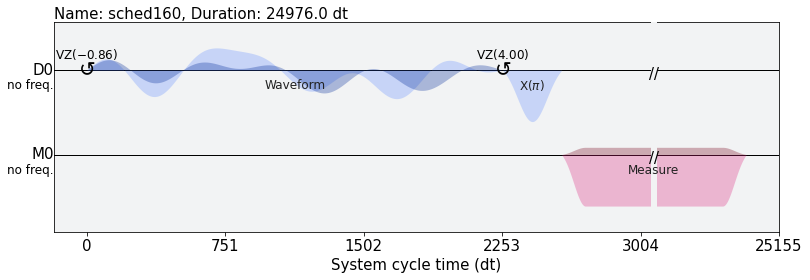

In [81]:
reference_schedules, interleaved_schedules, expected_final_results = RB_z_schedules(1,2,'Q','P', print_schedule = False)
#reference_schedules[0][2].draw(label = True)
interleaved_schedules[0].draw(label = True)

In [82]:
def RB_experiment(m, n, base = 'Q', x_gate = 'Q', n_sequence=1,detuning = 0, print_schedule = True, print_result = True): #(m은 reference sequence 길이, n은 reference seqeucne 개수)
                                                                                #(n_sequence는 한번에 실행하는 sequence 개수)
           
    print(f'Selected {n} reference sequences with length {m}')
    reference_schedules, interleaved_schedules, expected_final_results = RB_z_schedules(m,n, base, x_gate, print_schedule = print_schedule)
    
    reference_fidelity_list = []
    interleaved_fidelity_list = []

    average_reference_fidelity = 0
    average_interleaved_fidelity = 0

    total_experiment_num = np.ceil(n/n_sequence)
    
    experiment_schedule = []
    experiment_result = []
    
    for k in range(n):        
        experiment_schedule.append(reference_schedules[k])
        experiment_result.append(expected_final_results[k])
        if ((k+1) % n_sequence == 0):
            print(f'reference schedule {np.arange(k+2-n_sequence,k+2).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result, detuning = detuning, print_result = print_result)
            average_reference_fidelity += sum(fidelity_list)
            reference_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
        elif (k == n-1):
            print(f'reference schedule {np.arange((total_experiment_num-1) * n_sequence +1,n+1).astype(np.int64).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result,detuning = detuning, print_result = print_result)
            average_reference_fidelity += sum(fidelity_list)
            reference_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
       
    for k in range(n):        
        experiment_schedule.append(interleaved_schedules[k])
        experiment_result.append(expected_final_results[k])
        if ((k+1) % n_sequence == 0):
            print(f'interleaved schedule {np.arange(k+2-n_sequence,k+2).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result, detuning = detuning, print_result = print_result)
            average_interleaved_fidelity += sum(fidelity_list)
            interleaved_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
        elif (k == n-1):
            print(f'interleaved schedule {np.arange((total_experiment_num-1) * n_sequence +1,n+1).astype(np.int64).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result, detuning = detuning, print_result = print_result)
            average_interleaved_fidelity += sum(fidelity_list)
            interleaved_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []

    
    average_reference_fidelity = average_reference_fidelity/n
    average_interleaved_fidelity = average_interleaved_fidelity/n
    
    print(f'The average reference fidelity is {average_reference_fidelity}')
    print(f'The average interleaved fidelity is {average_interleaved_fidelity}')
    print('#####' * 10)
    print('')
    return average_reference_fidelity, average_interleaved_fidelity


In [ ]:
def save_results(ms, reference_fidelity, interleaved_fidelity, file_name):
    np.savetxt('Randomized_benchmarking_results/m_'+ file_name + ".txt", ms)
    np.savetxt('Randomized_benchmarking_results/reference_'+ file_name + ".txt", reference_fidelity)
    np.savetxt('Randomized_benchmarking_results/interleaved_'+ file_name + ".txt", interleaved_fidelity)


In [ ]:
def load_results(file_name):
    ms = np.loadtxt('Randomized_benchmarking_results/m_'+ file_name + ".txt")
    reference_fidelity = np.loadtxt('Randomized_benchmarking_results/reference_'+ file_name + ".txt")
    interleaved_fidelity = np.loadtxt('Randomized_benchmarking_results/interleaved_'+ file_name + ".txt")
    return ms, reference_fidelity, interleaved_fidelity

In [ ]:
def fit_results(ms, reference, interleaved):
    fit_params1, y_fit1 = fit_function(ms,
                                 reference, 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m ),
                                 [0.95, 1])

    fit_params2, y_fit2 = fit_function(ms,
                                 interleaved, 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m ),
                                 [0.95, 1])



    plt.scatter(ms, reference, color='black')
    plt.scatter(ms, interleaved, color='blue')

    plt.plot(ms, y_fit1, color='red')
    plt.plot(ms, y_fit2, color='red')

    reference_fidelity = fit_params1[0] 
    gate_fidelity = fit_params2[0] * fit_params1[0]
    plt.xlabel("# of clifford gates", fontsize=15)
    plt.ylabel("fidelity", fontsize=15)
    plt.show()
    print('reference_fidelity =', reference_fidelity)
    print('interleaved_fidelity =', gate_fidelity)
    return reference_fidelity, gate_fidelity

### Base = 'Q', x_gate = 'Q', Detuning = 0

In [38]:
ms = np.arange(1,82,2)
experiment_num_per_m = 30

qiskit_average_reference_fidelity_per_m = np.zeros(len(ms))
qiskit_reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

qiskit_average_interleaved_fidelity_per_m = np.zeros(len(ms))
qiskit_interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [43]:
n_sequence = 15
for n in range(21):
    qiskit_average_reference_fidelity_per_m[n], qiskit_average_interleaved_fidelity_per_m[n] = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'Q',n_sequence =n_sequence)

Selected 30 reference sequences with length 1
schdeule 1
Randomly Selected Sequence: [8] / ['h']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 11 / ['zh']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 2
Randomly Selected Sequence: [16] / ['hs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 3
Randomly Selected Sequence: [10] / ['yh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Inte

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 23 / ['zshs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 24
Randomly Selected Sequence: [13] / ['xsh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 25
Randomly Selected Sequence: [13] / ['xsh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate f

Randomly Selected Sequence: [ 4 12 11] / ['s', 'sh', 'zh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 16 / ['hs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 26
Randomly Selected Sequence: [16  8 13] / ['hs', 'h', 'xsh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 20 / ['shs']
********************
schdeule 27
Randomly Selected Sequence: [22 15 20] / ['yshs', 'zsh', 'shs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [

Job Status: job has successfully run
result: {'0': 1015, '1': 9}
fidelity: 0.9912109375
result: {'0': 1015, '1': 9}
fidelity: 0.9912109375
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 1012, '1': 12}
fidelity: 0.98828125
result: {'0': 1012, '1': 12}
fidelity: 0.98828125
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 1014, '1': 10}
fidelity: 0.990234375
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 26, '1': 998}
fidelity: 0.974609375
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 39, '1': 985}
fidelity: 0.9619140625
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1007, '1': 17}
fidelity:

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 26
Randomly Selected Sequence: [13 17  1  1 16  0  1] / ['xsh', 'xhs', 'x', 'x', 'hs', 'I', 'x']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 8 / ['h']
********************
schdeule 27
Randomly Selected Sequence: [19 12  8  5 14 11 20] / ['zhs', 'sh', 'h', 'xs', 'ysh', 'zh', 'shs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
In

********************
schdeule 30
Randomly Selected Sequence: [ 4  2  0  2 19  0 15 21 21] / ['s', 'y', 'I', 'y', 'zhs', 'I', 'zsh', 'xshs', 'xshs']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 5 / ['xs']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
re

Job Status: job has successfully run
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 28, '1': 996}
fidelity: 0.97265625
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
result: {'0': 36, '1': 988}
fidelity: 0.96484375
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1010, '1': 14}
fidelity: 0.986328125
result: {'0': 1015, '1': 9}
fidelity: 0.9

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 20
Randomly Selected Sequence: [11  6 10 10  8  8 13  3  7 22  3 16 11] / ['zh', 'ys', 'yh', 'yh', 'h', 'h', 'xsh', 'z', 'zs', 'yshs', 'z', 'hs', 'zh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 3 / ['z']
********************
schdeule 21
Randomly Selected Sequence: [ 1  3 12 17 13 22  4  5  6 14 14 15 10] / ['x', 'z', 'sh', 'xhs', 'xsh', 'yshs', 's', 'xs', 'ys', 'ysh', 'ysh', 'zsh

Job Status: job has successfully run
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 1014, '1': 10}
fidelity: 0.990234375
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
The average reference fidelity is 0.9746419270833333
The average interleaved fidelity is 0.9716145833333333
##################################################

Selected 30 reference sequences with length 

Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 3 / ['z']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 17
Randomly Selected Sequence: [21  1 14 20 20  2 21  0 21  4  0  9 17  3  1] / ['xshs', 'x', 'ysh', 'shs', 'shs', 'y', 'xshs', 'I', 'xshs', 's', 'I', 'xh', 'xhs', 'z', 'x']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 5 / ['xs']
********************
schdeule 18
Randomly Selected Sequence: [23 11  0  8 12  2 11 15 22 13 13  3 23 21 21] / ['zshs', 'zh', 'I', 'h', 'sh', 'y', 'zh', 'zsh', 'yshs', '

Job Status: job has successfully run
result: {'0': 31, '1': 993}
fidelity: 0.9697265625
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 25, '1': 999}
fidelity: 0.9755859375
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 1010, '1': 14}
fidelit

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 20
Randomly Selected Sequence: [15 21 12 18 17  7 23  6 10 18 17 10  9 21  2 18 16] / ['zsh', 'xshs', 'sh', 'yhs', 'xhs', 'zs', 'zshs', 'ys', 'yh', 'yhs', 'xhs', 'yh', 'xh', 'xshs', 'y', 'yhs', 'hs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 21
Randomly Selected Sequence: [21  8  0 17 20  9 16 10  1 11 13  9 12 19 1

Job Status: job has successfully run
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
result: {'0': 47, '1': 977}
fid

********************
schdeule 21
Randomly Selected Sequence: [ 4  2 21 10  7  4  8 23  0  1 12 17 20  6  4  8 12 10 18] / ['s', 'y', 'xshs', 'yh', 'zs', 's', 'h', 'zshs', 'I', 'x', 'sh', 'xhs', 'shs', 'ys', 's', 'h', 'sh', 'yh', 'yhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 22
Randomly Selected Sequence: [15 16 18  4  8 18 11 10  6 15 15 12  5  3 10 12 19 10 15] / ['zsh', 'hs', 'yhs', 's', 'h', 'yhs', 'zh', 'yh', 'ys', 'zsh', 'zsh', 'sh', 'xs', 'z', 'yh', 'sh', 'zhs', 'yh', 'zsh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20,

Job Status: job has successfully run
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1010, '1': 14}
fidelity: 0.986328125
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 52, '1': 972}
fidelity: 0.94921875
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 44, '1': 980}
fidelity: 0.95703125
The average reference fidelity is 0.9752604166666666
The average interleaved fidelity is 0.9689778645833333
##################################################

Selected 30 reference sequences with length 21
sc

********************
schdeule 24
Randomly Selected Sequence: [15  9 12  5  2 17  8  1 16 12 23  1 22 21 18  3 16  6 17  1  5] / ['zsh', 'xh', 'sh', 'xs', 'y', 'xhs', 'h', 'x', 'hs', 'sh', 'zshs', 'x', 'yshs', 'xshs', 'yhs', 'z', 'hs', 'ys', 'xhs', 'x', 'xs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 16 / ['hs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 25
Randomly Selected Sequence: [ 3  2  4  3 14  8 11  1 21 15  4 19 16 21  9  8 19  3 15 23 13] / ['z', 'y', 's', 'z', 'ysh', 'h', 'zh', 'x', 'xshs', 'zsh', 's', 'zhs', 'hs', 'xshs', 'xh', 'h', 'zhs', 'z', 'zsh', 'zshs', 'xsh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 28
Randomly Selected Sequence: [ 3 18 15 12  4  3 22  6 20  3  2 17  1 21  1 16 23  6 22  2 11 20 19] / ['z', 'yhs', 'zsh', 'sh', 's', 'z', 'yshs', 'ys', 'shs', 'z', 'y', 'xhs', 'x', 'xshs', 'x', 'hs', 'zshs', 'ys', 'yshs', 'y', 'zh', 'shs', 'zhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 29
Randomly Selected Sequence: [ 8 17 21  3  4  3 1

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 2 / ['y']
********************
schdeule 20
Randomly Selected Sequence: [ 9 11  1 11 20 22 11 12 17 13 16 23 21 21  8 13 22 22  9  3  6  6  4 15
  1] / ['xh', 'zh', 'x', 'zh', 'shs', 'yshs', 'zh', 'sh', 'xhs', 'xsh', 'hs', 'zshs', 'xshs', 'xshs', 'h', 'xsh', 'yshs', 'yshs', 'xh', 'z', 'ys', 'ys', 's', 'zsh', 'x']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 21
Randomly Selec

Job Status: job has successfully run
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 985, '1': 39}
fidelity: 0.9619140625
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 56, '1': 968}
fidelity: 0.9453125
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 43, '1': 981}
fidelity: 0.9580078125
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 36, '1': 988}
fidelity: 0.96484375
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 38, '1': 986}
fidelity: 0.962890625
res

********************
schdeule 16
Randomly Selected Sequence: [ 8  2 20 16 19 20 20 12 16 21  5 20 17 11 23 21 21  6 11 18 16 18 18  2
 14 19  2] / ['h', 'y', 'shs', 'hs', 'zhs', 'shs', 'shs', 'sh', 'hs', 'xshs', 'xs', 'shs', 'xhs', 'zh', 'zshs', 'xshs', 'xshs', 'ys', 'zh', 'yhs', 'hs', 'yhs', 'yhs', 'y', 'ysh', 'zhs', 'y']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 17
Randomly Selected Sequence: [15  6  5 13  9  0  8 11  1 18 17 22  4 18 16 23 15  2  3  1  8  3  5 13
  0 15 19] / ['zsh', 'ys', 'xs', 'xsh', 'xh', 'I', 'h', 'zh', 'x', 'yhs', 'xhs', 'yshs', 's', 'yhs', 'hs', 'zshs', 'zsh', 'y', 'z', 'x', 'h', 'z', 'xs', 'xsh', 'I', 'zsh', 'zhs']
Reference Sequence: recove

Job Status: job has successfully run
result: {'0': 978, '1': 46}
fidelity: 0.955078125
result: {'0': 28, '1': 996}
fidelity: 0.97265625
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 981, '1': 43}
fidelity: 0.9580078125
result: {'0': 38, '1': 986}
fidelity: 0.962890625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 988, '1': 36}
fidelity: 0.964

Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 14
Randomly Selected Sequence: [14  1  0 18 22  4  6 20  4 23  4 19  9  2 12 10 22  9 21  9 23 22 16 19
 17 19  4 13 18] / ['ysh', 'x', 'I', 'yhs', 'yshs', 's', 'ys', 'shs', 's', 'zshs', 's', 'zhs', 'xh', 'y', 'sh', 'yh', 'yshs', 'xh', 'xshs', 'xh', 'zshs', 'yshs', 'hs', 'zhs', 'xhs', 'zhs', 's', 'xsh', 'yhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 14 / ['ysh']
*************

Job Status: job has successfully run
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 986, '1': 38}
fidelity: 0.962890625
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 29, '1': 995}
fidelity: 0.9716796875
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 53, '1': 971}
fidelity: 0.94824

Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 25
Randomly Selected Sequence: [23  5 16  0 11 21  9  1 11  1  6 13  5  0 18 16 15  4  8  8  2  0  8 16
 11  0  9 23 17  7  3] / ['zshs', 'xs', 'hs', 'I', 'zh', 'xshs', 'xh', 'x', 'zh', 'x', 'ys', 'xsh', 'xs', 'I', 'yhs', 'hs', 'zsh', 's', 'h', 'h', 'y', 'I', 'h', 'hs', 'zh', 'I', 'xh', 'zshs', 'xhs', 'zs', 'z']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
************

********************
schdeule 7
Randomly Selected Sequence: [ 4  6 19 13 23 23  6 17  0 13 23 17 22  0 11 16 22  0  7  0  7 17 21 23
 10 18 22  6 19  3 16  1  1] / ['s', 'ys', 'zhs', 'xsh', 'zshs', 'zshs', 'ys', 'xhs', 'I', 'xsh', 'zshs', 'xhs', 'yshs', 'I', 'zh', 'hs', 'yshs', 'I', 'zs', 'I', 'zs', 'xhs', 'xshs', 'zshs', 'yh', 'yhs', 'yshs', 'ys', 'zhs', 'z', 'hs', 'x', 'x']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 23 / ['zshs']
********************
schdeule 8
Randomly Selected Sequence: [ 9 20 22 14 13  8 18  1  9 11 12 15  2 22  3  6  2 16 10 17 17  5  2  4
  6  6 21 13 20 19 19 21 11] / ['xh', 'shs', 'yshs', 'ysh', 'xsh', 'h', 'yhs', 'x', 'xh', 'zh', 'sh', 'zsh', 'y', 'yshs', 'z', 'ys', 'y', 'hs', 'yh', '

********************
schdeule 30
Randomly Selected Sequence: [10  6 10 22 13 22 16  9  2  3 14 12  8 15  5  4 10  8 18  5  7 17 18  3
 22  9 23  1  6 21  7 21 11] / ['yh', 'ys', 'yh', 'yshs', 'xsh', 'yshs', 'hs', 'xh', 'y', 'z', 'ysh', 'sh', 'h', 'zsh', 'xs', 's', 'yh', 'h', 'yhs', 'xs', 'zs', 'xhs', 'yhs', 'z', 'yshs', 'xh', 'zshs', 'x', 'ys', 'xshs', 'zs', 'xshs', 'zh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: 

Randomly Selected Sequence: [17  5  8 16 15 11 14 18 23 23 19 12  4 10 10 23  5  9 16 21  6  8 10 21
 14 20  2  2 12 11 22 23 11 11 18] / ['xhs', 'xs', 'h', 'hs', 'zsh', 'zh', 'ysh', 'yhs', 'zshs', 'zshs', 'zhs', 'sh', 's', 'yh', 'yh', 'zshs', 'xs', 'xh', 'hs', 'xshs', 'ys', 'h', 'yh', 'xshs', 'ysh', 'shs', 'y', 'y', 'sh', 'zh', 'yshs', 'zshs', 'zh', 'zh', 'yhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 14 / ['ysh']
********************
schdeule 27
Randomly Selected Sequence: [22 12 11 23 12 17  3 12  8 10 10  7 15 23  3 16  2 18 15 22  8 19  8 19
 12 18 18 18  5  8 18  1 19  8 19] / ['yshs', 'sh', 'zh', 'zshs', 'sh', 'xhs', 'z', 'sh', 'h', 'yh', 'yh', 'zs', 'zsh', 'zshs', 'z', 'hs', 'y', 'yhs', 'zsh', 'yshs', 'h'

Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 4 / ['s']
Recovery Gate for Interleaved sequence: 1 / ['x']
********************
schdeule 20
Randomly Selected Sequence: [16 10 22  2 20 23  2 10 11  2  4 14 16  3 21  5  1  9 23  0  0  6  8  0
 18  1 22  9 23  6 23  7 13  1 10  1 12] / ['hs', 'yh', 'yshs', 'y', 'shs', 'zshs', 'y', 'yh', 'zh', 'y', 's', 'ysh', 'hs', 'z', 'xshs', 'xs', 'x', 'xh', 'zshs', 'I', 'I', 'ys', 'h', 'I', 'yhs', 'x', 'yshs', 'xh', 'zshs', 'ys', 'zshs', 'zs', 'xsh', 'x', 'yh', 'x', 'sh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 13 / ['xsh']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 21
Randomly S

Job Status: job has successfully run
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 1013, '1': 11}
fidelity: 0.9892578125
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 62, '1': 962}
fidelity: 0.939453125
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 43, '1': 981}
fidelity: 0.9580078125
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 1010, '1': 14}
fidelity: 0.986328125
result: {'0': 1014, '1': 10}
fidelity: 0.990234375
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 32, '1': 992}
fidelity: 0.96875
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 997, '1': 27}
fidelity: 0

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 3 / ['z']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
schdeule 24
Randomly Selected Sequence: [22 23  4  7  4  2 23 12 11  7 18  1  6  0  9  1 21 20 18 18  5  4  2 22
  5  1 10 16  8  4 16 20  1 14 15 22 13 17 14] / ['yshs', 'zshs', 's', 'zs', 's', 'y', 'zshs', 'sh', 'zh', 'zs', 'yhs', 'x', 'ys', 'I', 'xh', 'x', 'xshs', 'shs', 'yhs', 'yhs', 'xs', 's', 'y', 'yshs', 'xs', 'x', 'yh', 'hs', 'h', 's', 'hs', 'shs', 'x', 'ysh', 'zsh', 'yshs', 'xsh', 'xhs', 'ysh']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequ

Job Status: job has successfully run
result: {'0': 982, '1': 42}
fidelity: 0.958984375
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
result: {'0': 56, '1': 968}
fidelity: 0.9453125
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 61, '1': 963}
fidelity: 0.9404296875
result: {'0': 66, '1': 958}
fidelity: 0.935546875
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 54, '1': 970}
fidelity: 0.947265625
The average reference fidelity is 0.96787109375
The average interleaved fidelity is 0.9569661458333333
##################################################

Selected 30 reference sequences with length 41
schdeule

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 8 / ['h']
********************
schdeule 13
Randomly Selected Sequence: [19 13 16 18 19  7 18  1 15  6  9 18 13 15 15  4  1  7  0  3 23 16  9  8
  3  7 19  7  0 17  2 19 23 23  5  6 11 17  2 11  5] / ['zhs', 'xsh', 'hs', 'yhs', 'zhs', 'zs', 'yhs', 'x', 'zsh', 'ys', 'xh', 'yhs', 'xsh', 'zsh', 'zsh', 's', 'x', 'zs', 'I', 'z', 'zshs', 'hs', 'xh', 'h', 'z', 'zs', 'zhs', 'zs', 'I', 'xhs', 'y', 'zhs', 'zshs', 'zshs', 'xs', 'ys', 'zh', 'xhs', 'y', 'zh', 'xs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 

********************
schdeule 28
Randomly Selected Sequence: [19 22 12  1 13 20  8 15  4 17 11 17  5  5 20 21  5  4 14 20 10 11 13 12
  1 10 21 21  2 20 21 21  5  2  9 12 14 18 22 15  3] / ['zhs', 'yshs', 'sh', 'x', 'xsh', 'shs', 'h', 'zsh', 's', 'xhs', 'zh', 'xhs', 'xs', 'xs', 'shs', 'xshs', 'xs', 's', 'ysh', 'shs', 'yh', 'zh', 'xsh', 'sh', 'x', 'yh', 'xshs', 'xshs', 'y', 'shs', 'xshs', 'xshs', 'xs', 'y', 'xh', 'sh', 'ysh', 'yhs', 'yshs', 'zsh', 'z']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
schdeule 29
Randomly Selected Sequence: [ 3 17 14 19  8 11 11 13 22 16  7 20 23  6 14  0 16 23  8  4  4 12  6 20
 21 18 23 20  1  9 15 15  7 17 10 15  2  5 18 12 23] / ['z', 'xhs', 'ysh', 'zhs', 'h', 'zh', 'zh

In [45]:
n_sequence = 15
for n in range(21,41):
    qiskit_average_reference_fidelity_per_m[n], qiskit_average_interleaved_fidelity_per_m[n] = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'Q',n_sequence =n_sequence)

Selected 30 reference sequences with length 43
schdeule 1
Randomly Selected Sequence: [ 8 19 23  7 13 19 20  2  3  2  7 15 20 17  2 10  5  2 16 21 15  0  9 15
  7 18  6  8 16 23  8  4 20 12  3  9 15 15 16 23 12  5  7] / ['h', 'zhs', 'zshs', 'zs', 'xsh', 'zhs', 'shs', 'y', 'z', 'y', 'zs', 'zsh', 'shs', 'xhs', 'y', 'yh', 'xs', 'y', 'hs', 'xshs', 'zsh', 'I', 'xh', 'zsh', 'zs', 'yhs', 'ys', 'h', 'hs', 'zshs', 'h', 's', 'shs', 'sh', 'z', 'xh', 'zsh', 'zsh', 'hs', 'zshs', 'sh', 'xs', 'zs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 2
Randomly Selected Sequence: [17  4 11  5  6  3 11  7 14 23  9  2 23 16  3  0 12 13 11 16  7 13 14  5
 15  9  0 11 23  8 13 17  2 12 19 13  6 11 

 22 16  0 18 16  7  2  8 17  2 13 14 15  2 19 23  4  4 21] / ['x', 'xs', 'sh', 'shs', 'sh', 'xh', 'z', 'zs', 'zsh', 'ys', 'ys', 'zhs', 'zhs', 'xhs', 'h', 'yh', 'xh', 'hs', 'ys', 'hs', 'yshs', 'yh', 's', 'sh', 'yshs', 'hs', 'I', 'yhs', 'hs', 'zs', 'y', 'h', 'xhs', 'y', 'xsh', 'ysh', 'zsh', 'y', 'zhs', 'zshs', 's', 's', 'xshs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 8 / ['h']
********************
schdeule 15
Randomly Selected Sequence: [19  0 20  2  7 23 20  9 19  0 10 20  5 12 20 20 16 13  9 16 17  4  3  5
 23 14  8  0 21 12 14 12 20  3 18  3  9 15 19  6  0  7  9] / ['zhs', 'I', 'shs', 'y', 'zs', 'zshs', 'shs', 'xh', 'zhs', 'I', 'yh', 'shs', 'xs', 'sh', 'shs', 'shs', 'hs', 'xsh', 'xh', 'hs', 'xhs', 's', 'z', 'xs', '

********************
schdeule 25
Randomly Selected Sequence: [ 2  7  9  6 20 20 17  4 10 14 22 12 22 19  0 18 21 13  3 11  5 23 13 16
 21 17 20  3 11 18 12 18  7 19 20  3 23 14 22 21 19  1 16] / ['y', 'zs', 'xh', 'ys', 'shs', 'shs', 'xhs', 's', 'yh', 'ysh', 'yshs', 'sh', 'yshs', 'zhs', 'I', 'yhs', 'xshs', 'xsh', 'z', 'zh', 'xs', 'zshs', 'xsh', 'hs', 'xshs', 'xhs', 'shs', 'z', 'zh', 'yhs', 'sh', 'yhs', 'zs', 'zhs', 'shs', 'z', 'zshs', 'ysh', 'yshs', 'xshs', 'zhs', 'x', 'hs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 26
Randomly Selected Sequence: [ 6 19  2 18 23 10  9  5  5  7 23 10  1 22 18  4 10  1 21  6 14 12  8  1
  7 13 19  4 11  2  3 14  6 21 19 19 12  3 12 19  7 14  2]

********************
schdeule 13
Randomly Selected Sequence: [19  8 11 20 13  8 20 21  9  6 14  3 21 12 13 18  5  1 20 20 18 20 20  5
  4 15  4  4  4 14  0  6 22  7  4  2 13 20 23 19 17  9 20  6  3] / ['zhs', 'h', 'zh', 'shs', 'xsh', 'h', 'shs', 'xshs', 'xh', 'ys', 'ysh', 'z', 'xshs', 'sh', 'xsh', 'yhs', 'xs', 'x', 'shs', 'shs', 'yhs', 'shs', 'shs', 'xs', 's', 'zsh', 's', 's', 's', 'ysh', 'I', 'ys', 'yshs', 'zs', 's', 'y', 'xsh', 'shs', 'zshs', 'zhs', 'xhs', 'xh', 'shs', 'ys', 'z']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 14
Randomly Selected Sequence: [19  1  1  7 10  9  2  8  4  5  2 20 22 10 19  1 20 14 21 16 18 17  5 20
  4 16 22 22 18 19 13 13 17  9  9 10  1 15  2  8  

********************
schdeule 26
Randomly Selected Sequence: [11  8  8 13  1 20 10  0 18 12 16 21  2  8 13  3 12  5 23 14 14 21  4 11
  7  8 17 14  7 13 11 12 13 12 15  5  7  0 21  3 14 21  4 18  7] / ['zh', 'h', 'h', 'xsh', 'x', 'shs', 'yh', 'I', 'yhs', 'sh', 'hs', 'xshs', 'y', 'h', 'xsh', 'z', 'sh', 'xs', 'zshs', 'ysh', 'ysh', 'xshs', 's', 'zh', 'zs', 'h', 'xhs', 'ysh', 'zs', 'xsh', 'zh', 'sh', 'xsh', 'sh', 'zsh', 'xs', 'zs', 'I', 'xshs', 'z', 'ysh', 'xshs', 's', 'yhs', 'zs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 16 / ['hs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 27
Randomly Selected Sequence: [ 4 21 11  3 20 10  2 22  5 19  7 22  9  7 21 22 23  6 13  8  6 20  0  9
  1 12  0 22 21  1 23 11 16 11 15 17 10  0 22  2 

********************
schdeule 15
Randomly Selected Sequence: [ 7 21  8 17  2 15  6 19  9 22 13  9  8 15 13  3 23 14 14  2 16 19 17 22
  9  7 12 23  1 10 22  4 14  8 15 11  8  5  1  0  2 23  7 13 22 17  6] / ['zs', 'xshs', 'h', 'xhs', 'y', 'zsh', 'ys', 'zhs', 'xh', 'yshs', 'xsh', 'xh', 'h', 'zsh', 'xsh', 'z', 'zshs', 'ysh', 'ysh', 'y', 'hs', 'zhs', 'xhs', 'yshs', 'xh', 'zs', 'sh', 'zshs', 'x', 'yh', 'yshs', 's', 'ysh', 'h', 'zsh', 'zh', 'h', 'xs', 'x', 'I', 'y', 'zshs', 'zs', 'xsh', 'yshs', 'xhs', 'ys']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 16
Randomly Selected Sequence: [ 2 22 10 17 12 19 11  5 20 11 14  6 11  2  4 20 23 16  4  1 15  4  7 17
  0  8 18  0 16 16 23 

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 27
Randomly Selected Sequence: [ 0  2 15  6 22 11  6  6  0 18 19  0 20 20 10 22  2 19  8  8 11 19 18 14
 18  9 15  6  0  9 19 14  4 18  4 21 16 16  3  6 20 19  1 12 14 19  9] / ['I', 'y', 'zsh', 'ys', 'yshs', 'zh', 'ys', 'ys', 'I', 'yhs', 'zhs', 'I', 'shs', 'shs', 'yh', 'yshs', 'y', 'zhs', 'h', 'h', 'zh', 'zhs', 'yhs', 'ysh', 'yhs', 'xh', 'zsh', 'ys', 'I', 'xh', 'zhs', 'ysh', 's', 'yhs', 's', 'xshs', 'hs', 'hs', 'z', 'ys', 'shs', 'zhs', 'x', 'sh', 'ysh', 'zhs', 'xh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery 

schdeule 9
Randomly Selected Sequence: [12 12 17 12  2  8  3 16  0 13 17  7 15  3  8  4 11 17 17 18 12  4 23 17
 18 12 19  7  2  2  4  1  3 11  4  1 17 19 16  6 17 13  0 22 21 15  1 23
  4] / ['sh', 'sh', 'xhs', 'sh', 'y', 'h', 'z', 'hs', 'I', 'xsh', 'xhs', 'zs', 'zsh', 'z', 'h', 's', 'zh', 'xhs', 'xhs', 'yhs', 'sh', 's', 'zshs', 'xhs', 'yhs', 'sh', 'zhs', 'zs', 'y', 'y', 's', 'x', 'z', 'zh', 's', 'x', 'xhs', 'zhs', 'hs', 'ys', 'xhs', 'xsh', 'I', 'yshs', 'xshs', 'zsh', 'x', 'zshs', 's']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 10
Randomly Selected Sequence: [ 2  3  3 16 20 12  4 17  8 15 13  0  7 21 15 11 19 19 15  6  4 22  5 13
  4 13 16  7  1  5 11 13 11  3  5  5  0 17  0 21 16 19  5  9

********************
schdeule 28
Randomly Selected Sequence: [13  5  3 22 20 15 21 15 13 15 16 23  8 22 15  6 23  4 14 11  5 20  3 21
 19  1 15  4 10  8 14  4 23 17 22 18 22 22 17 23 16  7  4  3  4 21 10  6
 18] / ['xsh', 'xs', 'z', 'yshs', 'shs', 'zsh', 'xshs', 'zsh', 'xsh', 'zsh', 'hs', 'zshs', 'h', 'yshs', 'zsh', 'ys', 'zshs', 's', 'ysh', 'zh', 'xs', 'shs', 'z', 'xshs', 'zhs', 'x', 'zsh', 's', 'yh', 'h', 'ysh', 's', 'zshs', 'xhs', 'yshs', 'yhs', 'yshs', 'yshs', 'xhs', 'zshs', 'hs', 'zs', 's', 'z', 's', 'xshs', 'yh', 'ys', 'yhs']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 29
Randomly Selected Sequence: [23 19 20 21 10 14 13 23  5  3  8 16  0 23  9 17 15 17 18  1  0 14  6  7
 13 16 10 14 20

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 21
Randomly Selected Sequence: [ 2  3  3  5  0 19 11  1 12 22  6  8 19 13  4  3  7 23  8  4  9  5  5  4
 14 21  6 13  4 21 13 13 11  0  4 18 20 18 16 17 10 16 10 23 23 18  1  1
 12  7 22] / ['y', 'z', 'z', 'xs', 'I', 'zhs', 'zh', 'x', 'sh', 'yshs', 'ys', 'h', 'zhs', 'xsh', 's', 'z', 'zs', 'zshs', 'h', 's', 'xh', 'xs', 'xs', 's', 'ysh', 'xshs', 'ys', 'xsh', 's', 'xshs', 'xsh', 'xsh', 'zh', 'I', 's', 'yhs', 'shs', 'yhs', 'hs', 'xhs', 'yh', 'hs', 'yh', 'zshs', 'zshs', 'yhs', 'x', 'x', 'sh', 'zs', 'yshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gat

Job Status: job has successfully run
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 57, '1': 967}
fidelity: 0.9443359375
result: {'0': 63, '1': 961}
fidelity: 0.9384765625
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 57, '1': 967}
fidelity: 0.9443359375
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 61, '1': 963}
fidelity: 0.9404296875
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 43, '1': 981}
fidelity: 0.9580078125
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 997, '1': 27}
fidelit

********************
schdeule 9
Randomly Selected Sequence: [21  5 15 18 13 22 13 16  8  6 16  0 16 14  6 23 21 22 14  2 12  7 19  7
  2 16 22  0  3  5 20  1 21 14 17 18  5  0  2 10 18 17  9 19 13 16 21 13
 21  9  7 20  3] / ['xshs', 'xs', 'zsh', 'yhs', 'xsh', 'yshs', 'xsh', 'hs', 'h', 'ys', 'hs', 'I', 'hs', 'ysh', 'ys', 'zshs', 'xshs', 'yshs', 'ysh', 'y', 'sh', 'zs', 'zhs', 'zs', 'y', 'hs', 'yshs', 'I', 'z', 'xs', 'shs', 'x', 'xshs', 'ysh', 'xhs', 'yhs', 'xs', 'I', 'y', 'yh', 'yhs', 'xhs', 'xh', 'zhs', 'xsh', 'hs', 'xshs', 'xsh', 'xshs', 'xh', 'zs', 'shs', 'z']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 10
Randomly Selected Sequence: [12 14 21  5 13 21  3 15 18  8 22 22 12 

********************
schdeule 27
Randomly Selected Sequence: [ 2 10 17 11 15  6 14  5  3  8 20  1 22  9 14 17 22 18 16 20 17  4  8  9
 13 11 21  5 23 22 16 13  4  8 12  6 10  9 19 23  0 13  2 18  8  3  8 16
 19 21 22 12  4] / ['y', 'yh', 'xhs', 'zh', 'zsh', 'ys', 'ysh', 'xs', 'z', 'h', 'shs', 'x', 'yshs', 'xh', 'ysh', 'xhs', 'yshs', 'yhs', 'hs', 'shs', 'xhs', 's', 'h', 'xh', 'xsh', 'zh', 'xshs', 'xs', 'zshs', 'yshs', 'hs', 'xsh', 's', 'h', 'sh', 'ys', 'yh', 'xh', 'zhs', 'zshs', 'I', 'xsh', 'y', 'yhs', 'h', 'z', 'h', 'hs', 'zhs', 'xshs', 'yshs', 'sh', 's']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 1 / ['x']
********************
schdeule 28
Randomly Selected Sequence: [13 15  7 15  5 19 18 22 14 14 20 13  6 22  0  0  9  9 11 22 12 

********************
schdeule 15
Randomly Selected Sequence: [19  2 17  9 18 16 16 12  4  2 15 19 17 13 13 10  1  6  7 14 12 23 11 13
 22 14  6 23 21  3  4 15 20  5 10  8  1  8  7  6 22 10  9  5  2 10 23 23
 16  5 15  7  4  9 10] / ['zhs', 'y', 'xhs', 'xh', 'yhs', 'hs', 'hs', 'sh', 's', 'y', 'zsh', 'zhs', 'xhs', 'xsh', 'xsh', 'yh', 'x', 'ys', 'zs', 'ysh', 'sh', 'zshs', 'zh', 'xsh', 'yshs', 'ysh', 'ys', 'zshs', 'xshs', 'z', 's', 'zsh', 'shs', 'xs', 'yh', 'h', 'x', 'h', 'zs', 'ys', 'yshs', 'yh', 'xh', 'xs', 'y', 'yh', 'zshs', 'zshs', 'hs', 'xs', 'zsh', 'zs', 's', 'xh', 'yh']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 3 / ['z']
********************
schdeule 16
Randomly Selected Sequence: [ 8  2 12 13  6  5 21  1 13  2 23  6 17  7  2

Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 13 / ['xsh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 977, '1': 47}
fidelity: 0.9541015625
result: {'0': 977, '1': 47}
fidelity: 0.9541015625
result: {'0': 27, '1': 997}
fidelity: 0.9736328125
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 964, '1': 60}
fidelity: 0.94140625
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 982, '1': 42}
fidelity: 0.958984375
result: {'0': 968, '1': 56}
fidelity: 0.9453125
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 979, '1': 45}
fidelity: 0.9

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
********************
schdeule 16
Randomly Selected Sequence: [ 2 18 18 10  5 23 15 23 13  8 15 15  5  8 15  7  5 19 21 20 10 11  6 17
  0 18  8 15 22  8 11 19 21  9  9  8 22 15 19 13 19  6 14 19 20 10 15 18
 12 23 13  5 10 19 13 22  0] / ['y', 'yhs', 'yhs', 'yh', 'xs', 'zshs', 'zsh', 'zshs', 'xsh', 'h', 'zsh', 'zsh', 'xs', 'h', 'zsh', 'zs', 'xs', 'zhs', 'xshs', 'shs', 'yh', 'zh', 'ys', 'xhs', 'I', 'yhs', 'h', 'zsh', 'yshs', 'h', 'zh', 'zhs', 'xshs', 'xh', 'xh', 'h', 'yshs', 'zsh', 'zhs', 'xsh', 'zhs', 'ys', 'ysh', 'zhs', 'shs', 'yh', 'zsh', 'yhs', 'sh', 'zshs', 'xsh', 'xs', 'yh', 'zhs', 'xsh', 'yshs', 'I']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14]

Job Status: job has successfully run
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 43, '1': 981}
fidelity: 0.9580078125
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 63, '1': 961}
fidelity: 0.9384765625
result: {'0': 980, '1': 44}
fidelity: 0.95703125
result: {'0': 985, '1': 39}
fidelity: 0.9619140625
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 52, '1': 972}
fidelity: 0.94921875
result: {'0': 994, '1': 30}
fidelity: 0.970703125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1007, '1': 17}
fidelity: 0.

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 19
Randomly Selected Sequence: [12 12  3  2  8 19 19 17 17 17 13  0  0 22 12 20 12 19 14  8  4 22  2  7
 14  0 19 11  0 18 20  3  1  9  4 20  7 12 21  4 23 17 19 12 15 15  6 13
  0  3 15  3 22 15  1 18  3 12  2] / ['sh', 'sh', 'z', 'y', 'h', 'zhs', 'zhs', 'xhs', 'xhs', 'xhs', 'xsh', 'I', 'I', 'yshs', 'sh', 'shs', 'sh', 'zhs', 'ysh', 'h', 's', 'yshs', 'y', 'zs', 'ysh', 'I', 'zhs', 'zh', 'I', 'yhs', 'shs', 'z', 'x', 'xh', 's', 'shs', 'zs', 'sh', 'xshs', 's', 'zshs', 'xhs', 'zhs', 'sh', 'zsh', 'zsh', 'ys', 'xsh', 'I', 'z', 'zsh', 'z', 'yshs', 'zsh', 'x', 'yhs', 'z', 'sh', 'y']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6]

Job Status: job has successfully run
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 56, '1': 968}
fidelity: 0.9453125
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1003, '1': 21}
fidelity: 0.

Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 15 / ['zsh']
********************
schdeule 19
Randomly Selected Sequence: [10  3 14 10  5 12  6  3 23 11 23 14 19  9 10  8  1 23 16  7 13  8 23  3
 16  1 17 23 11 15 22 19 23 22  4 20  0 12 15 12 10  0 12  4 16 16  3 16
  4  1  2  1 11 22 20 22  9  3 23  9  6] / ['yh', 'z', 'ysh', 'yh', 'xs', 'sh', 'ys', 'z', 'zshs', 'zh', 'zshs', 'ysh', 'zhs', 'xh', 'yh', 'h', 'x', 'zshs', 'hs', 'zs', 'xsh', 'h', 'zshs', 'z', 'hs', 'x', 'xhs', 'zshs', 'zh', 'zsh', 'yshs', 'zhs', 'zshs', 'yshs', 's', 'shs', 'I', 'sh', 'zsh', 'sh', 'yh', 'I', 'sh', 's', 'hs', 'hs', 'z', 'hs', 's', 'x', 'y', 'x', 'zh', 'yshs', 'shs', 'yshs', 'xh', 'z', 'zshs', 'xh', 'ys']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate

Job Status: job has successfully run
result: {'0': 65, '1': 959}
fidelity: 0.9365234375
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 60, '1': 964}
fidelity: 0.94140625
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 986, '1': 38}
fidelity: 0.962890625
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 44, '1': 980}
fidelity: 0.95703125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 42, '1': 982}
fidelity: 0.9

********************
schdeule 9
Randomly Selected Sequence: [21 17 12  9 10 10  4 21  4  2  5 16  0  0 19 10 22 12  3 20 23  1 15 18
  2  3 14 22 11 11 11 12  5 18  6 18  9  2  4  4  8 12 23 14 13  7 14 21
 23 22  8 19  4  5 13  5  6  8  8 16  4  7 23] / ['xshs', 'xhs', 'sh', 'xh', 'yh', 'yh', 's', 'xshs', 's', 'y', 'xs', 'hs', 'I', 'I', 'zhs', 'yh', 'yshs', 'sh', 'z', 'shs', 'zshs', 'x', 'zsh', 'yhs', 'y', 'z', 'ysh', 'yshs', 'zh', 'zh', 'zh', 'sh', 'xs', 'yhs', 'ys', 'yhs', 'xh', 'y', 's', 's', 'h', 'sh', 'zshs', 'ysh', 'xsh', 'zs', 'ysh', 'xshs', 'zshs', 'yshs', 'h', 'zhs', 's', 'xs', 'xsh', 'xs', 'ys', 'h', 'h', 'hs', 's', 'zs', 'zshs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
s

Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 8 / ['h']
********************
schdeule 19
Randomly Selected Sequence: [14 15  6  3 18  3 20 20  7  4 10  8  9 21  8 13 20  2  4 12 23 16 20 23
 21  7  1  0  6  0 20 11 14  8  5 21 22 14 16  2 14 21  5 19 13  9  4 15
  0  6 16 12 16 19 17  2 22 21  4 14 12 13 20] / ['ysh', 'zsh', 'ys', 'z', 'yhs', 'z', 'shs', 'shs', 'zs', 's', 'yh', 'h', 'xh', 'xshs', 'h', 'xsh', 'shs', 'y', 's', 'sh', 'zshs', 'hs', 'shs', 'zshs', 'xshs', 'zs', 'x', 'I', 'ys', 'I', 'shs', 'zh', 'ysh', 'h', 'xs', 'xshs', 'yshs', 'ysh', 'hs', 'y', 'ysh', 'xshs', 'xs', 'zhs', 'xsh', 'xh', 's', 'zsh', 'I', 'ys', 'hs', 'sh', 'hs', 'zhs', 'xhs', 'y', 'yshs', 'xshs', 's', 'ysh', 'sh', 'xsh', 'shs']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: 

Job Status: job has successfully run
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 992, '1': 32}
fidelity: 0.96875
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 18
Randomly Selected Sequence: [ 9  5  7 13 23 17  0  1 13 10 20  7 11  8  7  5  3  4 21  7 17  4 22  3
 12  8 19 10  7 14 11  4  2 15 16 10 22 11  9 13  2  8 22 20  7 17 11 10
  1 15  9 14 10  2  6 16  5  5  9  7  8  9  6  8 16] / ['xh', 'xs', 'zs', 'xsh', 'zshs', 'xhs', 'I', 'x', 'xsh', 'yh', 'shs', 'zs', 'zh', 'h', 'zs', 'xs', 'z', 's', 'xshs', 'zs', 'xhs', 's', 'yshs', 'z', 'sh', 'h', 'zhs', 'yh', 'zs', 'ysh', 'zh', 's', 'y', 'zsh', 'hs', 'yh', 'yshs', 'zh', 'xh', 'xsh', 'y', 'h', 'yshs', 'shs', 'zs', 'xhs', 'zh', 'yh', 'x', 'zsh', 'xh', 'ysh', 'yh', 'y', 'ys', 'hs', 'xs', 'xs', 'xh', 'zs', 'h', 'xh', 'ys', 'h', 'hs']
Reference S

Job Status: job has successfully run
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 61, '1': 963}
fidelity: 0.9404296875
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 45, '1': 979}
fidelity: 0.9560546875
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 28, '1': 996}
fidelity: 0.97265625
result: {'0': 66, '1': 958}
fidelity: 0.935546875
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 78, '1': 946}
fidelity: 0.923828125
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 995, '1': 29}
fidelity: 0.9716796875


Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 13 / ['xsh']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
********************
schdeule 19
Randomly Selected Sequence: [ 9  6  4 12 15  8  1  6  2 13  4  0 17 17 20 14  5 22 11 15  6 22  9  1
 19  1 15 11 16  0  1 19 11  0 11 15 12 23 11 15 14  2 12 12 13 22  0 12
 10 14 12 21 11 16 12 19  5 20  3  3  3  9 12  8  6 13 22] / ['xh', 'ys', 's', 'sh', 'zsh', 'h', 'x', 'ys', 'y', 'xsh', 's', 'I', 'xhs', 'xhs', 'shs', 'ysh', 'xs', 'yshs', 'zh', 'zsh', 'ys', 'yshs', 'xh', 'x', 'zhs', 'x', 'zsh', 'zh', 'hs', 'I', 'x', 'zhs', 'zh', 'I', 'zh', 'zsh', 'sh', 'zshs', 'zh', 'zsh', 'ysh', 'y', 'sh', 'sh', 'xsh', 'yshs', 'I', 'sh', 'yh', 'ysh', 'sh', 'xshs', 'zh', 'hs', 'sh', 'zhs', 'xs', 'shs', 'z', 'z', 'z', 'xh', 'sh', 'h', 'ys', 

Job Status: job has successfully run
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 56, '1': 968}
fidelity: 0.9453125
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 36, '1': 988}
fidelity: 0.96484375
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 52, '1': 972}
fidelity: 0.94921875
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 43, '1': 981}
fidelity: 0.9580078125


Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 16 / ['hs']
Recovery Gate for Interleaved sequence: 21 / ['xshs']
********************
schdeule 19
Randomly Selected Sequence: [ 0  5 12 15 22  6  1  5 22 18 15 19 23  3  5  5 16 17 13  9 20  4 19 21
  6 19 20  6 14 12  7 12 12 23 21 18 20 20  4  0 17  9  3 11 19  0 12  8
 15  4 23  0  9 23  7 20 15  6 10 18  6 10  8  8 14  1  6 21 19] / ['I', 'xs', 'sh', 'zsh', 'yshs', 'ys', 'x', 'xs', 'yshs', 'yhs', 'zsh', 'zhs', 'zshs', 'z', 'xs', 'xs', 'hs', 'xhs', 'xsh', 'xh', 'shs', 's', 'zhs', 'xshs', 'ys', 'zhs', 'shs', 'ys', 'ysh', 'sh', 'zs', 'sh', 'sh', 'zshs', 'xshs', 'yhs', 'shs', 'shs', 's', 'I', 'xhs', 'xh', 'z', 'zh', 'zhs', 'I', 'sh', 'h', 'zsh', 's', 'zshs', 'I', 'xh', 'zshs', 'zs', 'shs', 'zsh', 'ys', 'yh', 'yhs', 'ys', 'yh', 'h', 'h', 'ysh', 'x', 'ys', 'xshs', 'zhs']
Reference Sequence: recovery gate for 0: [8, 11, 

********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 43, '1': 981}
fidelity: 0.9580078125
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 48, '1': 976}
fidelity: 0.953125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
resul

********************
schdeule 15
Randomly Selected Sequence: [13 19 15  8  5 10  4  8 18 19  3  6  8 16  3 23  6 21  9 11 12  4  5  6
  2  2  7 12  2 11 14  0 10 11  2 18  1 14  5  8  0 13 23 15 17 15 10  7
 23  7 22  8 13  5  7  6 21 21 12 16 14 22  2 23 23 13  9 21 17 19  5] / ['xsh', 'zhs', 'zsh', 'h', 'xs', 'yh', 's', 'h', 'yhs', 'zhs', 'z', 'ys', 'h', 'hs', 'z', 'zshs', 'ys', 'xshs', 'xh', 'zh', 'sh', 's', 'xs', 'ys', 'y', 'y', 'zs', 'sh', 'y', 'zh', 'ysh', 'I', 'yh', 'zh', 'y', 'yhs', 'x', 'ysh', 'xs', 'h', 'I', 'xsh', 'zshs', 'zsh', 'xhs', 'zsh', 'yh', 'zs', 'zshs', 'zs', 'yshs', 'h', 'xsh', 'xs', 'zs', 'ys', 'xshs', 'xshs', 'sh', 'hs', 'ysh', 'yshs', 'y', 'zshs', 'zshs', 'xsh', 'xh', 'xshs', 'xhs', 'zhs', 'xs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 19

********************
schdeule 26
Randomly Selected Sequence: [18 19  1  1  0 20  2 16 15  1 16 13  1  0  0  0  5  6 11 18 17  4 22 21
  4 12  5  6  0  3  3  0 15 22 11 10 16 17 23  5  5  6  5  8  9  7 19  4
 14  7 21 19 22  5  3  9 21 17  4 14 17 23  3  3 13  3  1  3 22 15  6] / ['yhs', 'zhs', 'x', 'x', 'I', 'shs', 'y', 'hs', 'zsh', 'x', 'hs', 'xsh', 'x', 'I', 'I', 'I', 'xs', 'ys', 'zh', 'yhs', 'xhs', 's', 'yshs', 'xshs', 's', 'sh', 'xs', 'ys', 'I', 'z', 'z', 'I', 'zsh', 'yshs', 'zh', 'yh', 'hs', 'xhs', 'zshs', 'xs', 'xs', 'ys', 'xs', 'h', 'xh', 'zs', 'zhs', 's', 'ysh', 'zs', 'xshs', 'zhs', 'yshs', 'xs', 'z', 'xh', 'xshs', 'xhs', 's', 'ysh', 'xhs', 'zshs', 'z', 'z', 'xsh', 'z', 'x', 'z', 'yshs', 'zsh', 'ys']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for I

Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 14 / ['ysh']
********************
schdeule 17
Randomly Selected Sequence: [ 1  4  6  7 21  6 19  6  3  6 17 23  9 13  5  6 21 10  9 22  6  7  0  9
  9 17  5  1  1 17  2 15  4 20 18 23 12  2  8  6 13 16  3  4 22  1 22  1
 20 11  0 16  7 17 10 11 22 11  5  7 10  7 19  7 19 22  9  2  8 12  7 18
  2] / ['x', 's', 'ys', 'zs', 'xshs', 'ys', 'zhs', 'ys', 'z', 'ys', 'xhs', 'zshs', 'xh', 'xsh', 'xs', 'ys', 'xshs', 'yh', 'xh', 'yshs', 'ys', 'zs', 'I', 'xh', 'xh', 'xhs', 'xs', 'x', 'x', 'xhs', 'y', 'zsh', 's', 'shs', 'yhs', 'zshs', 'sh', 'y', 'h', 'ys', 'xsh', 'hs', 'z', 's', 'yshs', 'x', 'yshs', 'x', 'shs', 'zh', 'I', 'hs', 'zs', 'xhs', 'yh', 'zh', 'yshs', 'zh', 'xs', 'zs', 'yh', 'zs', 'zhs', 'zs', 'zhs', 'yshs', 'xh', 'y', 'h', 'sh', 'zs', 'yhs', 'y']
Reference Sequence: recove

Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 30
Randomly Selected Sequence: [22  7 15 18 21 12 23 15 20 21  6 15 11  0  5 15  7  5 22  9 16 12 16  1
  2  3  5  4 21 21 19  1 21  2 19  6  3  3  7 16 22  4 14  0 15 19  7 15
 17  1  5 16  2 17  4 19  4 20  5 21 20 21 19 18 22 18  2 17  5  0 19 12
  4] / ['yshs', 'zs', 'zsh', 'yhs', 'xshs', 'sh', 'zshs', 'zsh', 'shs', 'xshs', 'ys', 'zsh', 'zh', 'I', 'xs', 'zsh', 'zs', 'xs', 'yshs', 'xh', 'hs', 'sh', 'hs', 'x', 'y', 'z', 'xs', 's', 'xshs', 'xshs', 'zhs', 'x', 'xshs', 'y', 'zhs', 'ys', 'z', 'z', 'zs', 'hs', 'yshs', 's', 'ysh', 'I', 'zsh', 'zhs', 'zs', 'zsh', 'xhs', 'x', 'xs', 'hs', 'y', 'xhs', 's', 'zhs', 's', 'shs', 'xs', 'xshs', 'shs', 'xshs', 'zhs', 'yhs', 'yshs', 'yhs', 'y', 'xhs', 'xs', 'I', 'zhs', 'sh', 's']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 9
Randomly Selected Sequence: [20 18 12 12 11 22  6 13  1  7 12  0  8  0  7 19  1  1  2 18  6 11 22 17
 18 21  1 20  0 21 12 21 19 14 11  8  8  6 12 11  9  6 21  2 23 17 19  1
 17 20  3 20 12 15  4 23 21 17  8 11  9 11 11 22  7 20  0 21 10 23  0 11
 22 18  5] / ['shs', 'yhs', 'sh', 'sh', 'zh', 'yshs', 'ys', 'xsh', 'x', 'zs', 'sh', 'I', 'h', 'I', 'zs', 'zhs', 'x', 'x', 'y', 'yhs', 'ys', 'zh', 'yshs', 'xhs', 'yhs', 'xshs', 'x', 'shs', 'I', 'xshs', 'sh', 'xshs', 'zhs', 'ysh', 'zh', 'h', 'h', 'ys', 'sh', 'zh', 'xh', 'ys', 'xshs', 'y', 'zshs', 'xhs', 'zhs', 'x', 'xhs', 'shs', 'z', 'shs', 'sh', 'zsh', 's', 'zshs', 'xshs', 'xhs', 'h', 'zh', 'x

Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 7 / ['zs']
********************
schdeule 18
Randomly Selected Sequence: [21 16  9 10 22 14  7  0  1 14  4 22 22  6 19  8 13 15 16  3 19 13  5 22
  4 17  4 22  7 15 12  7 18  0 10 12 19  4 18  2 13  1 18 15  4  7 16  4
  4 21  8  9 17 18  6 15 23 13  5 15  3  7 22  9 15  3 10  4 14  4  2 15
 22 21 10] / ['xshs', 'hs', 'xh', 'yh', 'yshs', 'ysh', 'zs', 'I', 'x', 'ysh', 's', 'yshs', 'yshs', 'ys', 'zhs', 'h', 'xsh', 'zsh', 'hs', 'z', 'zhs', 'xsh', 'xs', 'yshs', 's', 'xhs', 's', 'yshs', 'zs', 'zsh', 'sh', 'zs', 'yhs', 'I', 'yh', 'sh', 'zhs', 's', 'yhs', 'y', 'xsh', 'x', 'yhs', 'zsh', 's', 'zs', 'hs', 's', 's', 'xshs', 'h', 'xh', 'xhs', 'yhs', 'ys', 'zsh', 'zshs', 'xsh', 'xs', 'zsh', 'z', 'zs',

Job Status: job has successfully run
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 60, '1': 964}
fidelity: 0.94140625
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 52, '1': 972}
fidelity: 0.94921875
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 44, '1': 980}
fidelity: 0.95703125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 50, '1': 974}
fidelity: 0.9511718

********************
schdeule 13
Randomly Selected Sequence: [18  3 10 12  2 19  9 16 22 21  3  7  3 21  3 17  9 19 16  8 21 18 15 16
  3  6  6  3 11  6 13 20  3 17 19 23 22  9  6 17  5  0 22 21  0 15 20 13
  4 12  4 16  5 17  3  3  8 23 19  8 20 14 14 21 17 22 11 20  1  5 19 12
 11 20  2  1 11] / ['yhs', 'z', 'yh', 'sh', 'y', 'zhs', 'xh', 'hs', 'yshs', 'xshs', 'z', 'zs', 'z', 'xshs', 'z', 'xhs', 'xh', 'zhs', 'hs', 'h', 'xshs', 'yhs', 'zsh', 'hs', 'z', 'ys', 'ys', 'z', 'zh', 'ys', 'xsh', 'shs', 'z', 'xhs', 'zhs', 'zshs', 'yshs', 'xh', 'ys', 'xhs', 'xs', 'I', 'yshs', 'xshs', 'I', 'zsh', 'shs', 'xsh', 's', 'sh', 's', 'hs', 'xs', 'xhs', 'z', 'z', 'h', 'zshs', 'zhs', 'h', 'shs', 'ysh', 'ysh', 'xshs', 'xhs', 'yshs', 'zh', 'shs', 'x', 'xs', 'zhs', 'sh', 'zh', 'shs', 'y', 'x', 'zh']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Fina

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 26
Randomly Selected Sequence: [ 2 11 19  6 12 19 21 15 17  6 15 14  4 15  7  5  1  7 23  0  4  9 19 21
 14  4  6 15  3  4  1 14 13 18 17 12  8 15 10 23 11 21  2 21  5 15  5 17
  6 20 19 22  9  5 11  9 15 13 21 19  1  6  2 13 14  3  1 22 12 14 18  0
 20 14  5 13 16] / ['y', 'zh', 'zhs', 'ys', 'sh', 'zhs', 'xshs', 'zsh', 'xhs', 'ys', 'zsh', 'ysh', 's', 'zsh', 'zs', 'xs', 'x', 'zs', 'zshs', 'I', 's', 'xh', 'zhs', 'xshs', 'ysh', 's', 'ys', 'zsh', 'z', 's', 'x', 'ysh', 'xsh', 'yhs', 'xhs', 'sh', 'h', 'zsh', 'yh', 'zshs', 'zh', 'xshs', 'y', 'xshs', 'xs', 'zsh', 'xs', 'xhs', 'ys', 'shs', 'zhs', 'yshs', 'xh', 'xs', 'zh', 'xh', 'zsh',

Job Status: job has successfully run
result: {'0': 83, '1': 941}
fidelity: 0.9189453125
result: {'0': 956, '1': 68}
fidelity: 0.93359375
result: {'0': 947, '1': 77}
fidelity: 0.9248046875
result: {'0': 79, '1': 945}
fidelity: 0.9228515625
result: {'0': 957, '1': 67}
fidelity: 0.9345703125
result: {'0': 954, '1': 70}
fidelity: 0.931640625
result: {'0': 84, '1': 940}
fidelity: 0.91796875
result: {'0': 955, '1': 69}
fidelity: 0.9326171875
result: {'0': 959, '1': 65}
fidelity: 0.9365234375
result: {'0': 63, '1': 961}
fidelity: 0.9384765625
result: {'0': 938, '1': 86}
fidelity: 0.916015625
result: {'0': 71, '1': 953}
fidelity: 0.9306640625
result: {'0': 941, '1': 83}
fidelity: 0.9189453125
result: {'0': 72, '1': 952}
fidelity: 0.9296875
result: {'0': 960, '1': 64}
fidelity: 0.9375
The average reference fidelity is 0.9614908854166667
The average interleaved fidelity is 0.9352213541666666
##################################################

Selected 30 reference sequences with length 79
schdeu

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 23 / ['zshs']
********************
schdeule 8
Randomly Selected Sequence: [14 13  8 20 21  2 12 11 20  8 10  2 19  7  7 10  7 11  0 23  0 21 13 16
  8 20  7  5 23 12  8 23 18  2 15 23 20  6 18 19 20  4 22  5 21 14  7 16
  1 17 22  2 19 10 13 15  6  6 13  9 17  6 11  2 23  4 21  7  5 17 20 12
 23  3 19  2 20 21  7] / ['ysh', 'xsh', 'h', 'shs', 'xshs', 'y', 'sh', 'zh', 'shs', 'h', 'yh', 'y', 'zhs', 'zs', 'zs', 'yh', 'zs', 'zh', 'I', 'zshs', 'I', 'xshs', 'xsh', 'hs', 'h', 'shs', 'zs', 'xs', 'zshs', 'sh', 'h', 'zshs', 'yhs', 'y', 'zsh', 'zshs', 'shs', 'ys', 'yhs', 'zhs', 'shs', 's', 'yshs', 'xs', 'xshs', 'ysh', 'zs', 'hs', 'x', 'xhs', 'yshs', 'y', 'zhs', 'yh', 'xsh', 'zsh'

********************
schdeule 15
Randomly Selected Sequence: [14 19 14  9  2 10 15  6  5  4  8 11 18 17 12 19  3  9 20 22  0  9 15  0
  7  5  6 23 18 18 11 19  7  3 19  3  0 14 16  5  2 16 21 10  0 13 13  1
  2 11  9 16  8  6 15  2 19  5  2 21 17 19  8 23  6 12 18 12 22 12  2 10
 15  4 11 20 23 20 14] / ['ysh', 'zhs', 'ysh', 'xh', 'y', 'yh', 'zsh', 'ys', 'xs', 's', 'h', 'zh', 'yhs', 'xhs', 'sh', 'zhs', 'z', 'xh', 'shs', 'yshs', 'I', 'xh', 'zsh', 'I', 'zs', 'xs', 'ys', 'zshs', 'yhs', 'yhs', 'zh', 'zhs', 'zs', 'z', 'zhs', 'z', 'I', 'ysh', 'hs', 'xs', 'y', 'hs', 'xshs', 'yh', 'I', 'xsh', 'xsh', 'x', 'y', 'zh', 'xh', 'hs', 'h', 'ys', 'zsh', 'y', 'zhs', 'xs', 'y', 'xshs', 'xhs', 'zhs', 'h', 'zshs', 'ys', 'sh', 'yhs', 'sh', 'yshs', 'sh', 'y', 'yh', 'zsh', 's', 'zh', 'shs', 'zshs', 'shs', 'ysh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]


  7 21  4 17  0 10 19] / ['xshs', 'ys', 'zshs', 'zs', 'xshs', 'x', 'yshs', 'yhs', 'zs', 'zhs', 'zsh', 'zsh', 'x', 'yshs', 'yhs', 'h', 'I', 'hs', 'sh', 'ysh', 'hs', 'I', 'xs', 'h', 'xh', 'I', 'h', 'yshs', 'sh', 'ysh', 'yshs', 'xh', 'hs', 'zshs', 'h', 'zshs', 's', 'ysh', 'zhs', 'x', 'xshs', 'ys', 'shs', 'zs', 'ys', 'I', 'y', 'yhs', 'zhs', 'zshs', 'xhs', 'x', 'zh', 'I', 'hs', 'xs', 'zs', 'ysh', 'xsh', 'xh', 'zs', 'yh', 'zsh', 'zshs', 'hs', 'yh', 'yshs', 'zhs', 'shs', 'y', 'xsh', 'zhs', 'zs', 'xshs', 's', 'xhs', 'I', 'yh', 'zhs']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 29
Randomly Selected Sequence: [19  5 22  7  2 23 21 22 17 21 11  8  6 22 17  4 23 12  8 10  1 16 14  3
  5 21  1 15 10  5 

Randomly Selected Sequence: [ 0  2  1  6 20 20  5  5  4  3 19 15 16 14 20  5  4  4 15  7 17 22 23 17
  7  9  9  1  5 19 11 21 15 13  1 22  3  5  1  4  4 15 15  2 11  8 11  9
 23  6  2 21 10 23 22  9  6 13 22 10 13  3 22 21  8 13 10  8  9 10  7 23
 15 21  5 13  6 19  4  2 14] / ['I', 'y', 'x', 'ys', 'shs', 'shs', 'xs', 'xs', 's', 'z', 'zhs', 'zsh', 'hs', 'ysh', 'shs', 'xs', 's', 's', 'zsh', 'zs', 'xhs', 'yshs', 'zshs', 'xhs', 'zs', 'xh', 'xh', 'x', 'xs', 'zhs', 'zh', 'xshs', 'zsh', 'xsh', 'x', 'yshs', 'z', 'xs', 'x', 's', 's', 'zsh', 'zsh', 'y', 'zh', 'h', 'zh', 'xh', 'zshs', 'ys', 'y', 'xshs', 'yh', 'zshs', 'yshs', 'xh', 'ys', 'xsh', 'yshs', 'yh', 'xsh', 'z', 'yshs', 'xshs', 'h', 'xsh', 'yh', 'h', 'xh', 'yh', 'zs', 'zshs', 'zsh', 'xshs', 'xs', 'xsh', 'ys', 'zhs', 's', 'y', 'ysh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expec

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 989, '1': 35}
fidelity: 0.9658203125
result: {'0': 57, '1': 967}
fidelity: 0.9443359375
result: {'0': 60, '1': 964}
fidelity: 0.94140625
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 981, '1': 43}
fidelity: 0.9580078125
result: {'0': 975, '1': 49}
fidelity: 0.9521484375
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 981, '1': 43}
fidelity: 0.9580078125
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 55, '1': 969}
fidelity: 0.94

In [88]:
n_sequence = 15
for n in range(41, 62):
    qiskit_average_reference_fidelity_per_m[n], qiskit_average_interleaved_fidelity_per_m[n] = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'Q',n_sequence =n_sequence)

Selected 30 reference sequences with length 90
schdeule 1
Randomly Selected Sequence: [ 7  4  8 14  9 13  5 12 10 11  4 10 19 22  0 15 11 15  0 16 12 14 15 23
 17  9  9 17 16  1 22 15 10 14 17 19  3  2 15 19  6 20 20  0  7 11 12 20
 21 16  8 12 10 21  3 17 14  4 10  4 20  9 22 19  7 11 15 11 16 23 21 11
  8 12  5 20 13  6  6  1 15  9 19  6 13 12 13 13 15 10] / ['zs', 's', 'h', 'ysh', 'xh', 'xsh', 'xs', 'sh', 'yh', 'zh', 's', 'yh', 'zhs', 'yshs', 'I', 'zsh', 'zh', 'zsh', 'I', 'hs', 'sh', 'ysh', 'zsh', 'zshs', 'xhs', 'xh', 'xh', 'xhs', 'hs', 'x', 'yshs', 'zsh', 'yh', 'ysh', 'xhs', 'zhs', 'z', 'y', 'zsh', 'zhs', 'ys', 'shs', 'shs', 'I', 'zs', 'zh', 'sh', 'shs', 'xshs', 'hs', 'h', 'sh', 'yh', 'xshs', 'z', 'xhs', 'ysh', 's', 'yh', 's', 'shs', 'xh', 'yshs', 'zhs', 'zs', 'zh', 'zsh', 'zh', 'hs', 'zshs', 'xshs', 'zh', 'h', 'sh', 'xs', 'shs', 'xsh', 'ys', 'ys', 'x', 'zsh', 'xh', 'zhs', 'ys', 'xsh', 'sh', 'xsh', 'xsh', 'zsh', 'yh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  rec

********************
schdeule 10
Randomly Selected Sequence: [ 7 10  4 21 18  6  2 12  9 23  7  6  7  2  7 16 20 20  9  4 12 16 20 20
 22 12 21 16  1  6 18 17 22 10 23  8 12 14  0  2  7 22 22 23 10 20 23 22
 15  0  3  6 21  3 21 20 11  3  1 12 21 14  6  5  1  5  7 14 14  3  8 15
 15 10 16 12  7 18 19 15 12 21 20 14 10  7 23  3  0 22] / ['zs', 'yh', 's', 'xshs', 'yhs', 'ys', 'y', 'sh', 'xh', 'zshs', 'zs', 'ys', 'zs', 'y', 'zs', 'hs', 'shs', 'shs', 'xh', 's', 'sh', 'hs', 'shs', 'shs', 'yshs', 'sh', 'xshs', 'hs', 'x', 'ys', 'yhs', 'xhs', 'yshs', 'yh', 'zshs', 'h', 'sh', 'ysh', 'I', 'y', 'zs', 'yshs', 'yshs', 'zshs', 'yh', 'shs', 'zshs', 'yshs', 'zsh', 'I', 'z', 'ys', 'xshs', 'z', 'xshs', 'shs', 'zh', 'z', 'x', 'sh', 'xshs', 'ysh', 'ys', 'xs', 'x', 'xs', 'zs', 'ysh', 'ysh', 'z', 'h', 'zsh', 'zsh', 'yh', 'hs', 'sh', 'zs', 'yhs', 'zhs', 'zsh', 'sh', 'xshs', 'shs', 'ysh', 'yh', 'zs', 'zshs', 'z', 'I', 'yshs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [1

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 21 / ['xshs']
********************
schdeule 24
Randomly Selected Sequence: [11 12 23  1 10  3  8 10  4  3 22  6 17 23 16 19 16 18 23 16  3  0  1 19
 18 19  0 12 11 19  5 22  3 21 15 16  8 14  6 20 23  3 13  8 21  8 10 11
 15 19  8 20  5 14  8  5 19  3 12  2  1 10  2  4 15  0 17 14 22  4 20 11
 12 19 17 10  5 11  6  7  6 21  5 13 17 16 10  1 22 17] / ['zh', 'sh', 'zshs', 'x', 'yh', 'z', 'h', 'yh', 's', 'z', 'yshs', 'ys', 'xhs', 'zshs', 'hs', 'zhs', 'hs', 'yhs', 'zshs', 'hs', 'z', 'I', 'x', 'zhs', 'yhs', 'zhs', 'I', 'sh', 'zh', 'zhs', 'xs', 'yshs', 'z', 'xshs', 'zsh', 'hs', 'h', 'ysh', 'ys', 'shs', 'zshs', 'z', 'xsh', 'h', 'xshs', 'h', 'yh', 'zh', 'zsh', 'zhs', 'h', 'shs'

Job Status: job has successfully run
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 969, '1': 55}
fidelity: 0.9462890625
result: {'0': 57, '1': 967}
fidelity: 0.9443359375
result: {'0': 66, '1': 958}
fidelity: 0.935546875
result: {'0': 972, '1': 52}
fidelity: 0.94921875
result: {'0': 978, '1': 46}
fidelity: 0.955078125
result: {'0': 74, '1': 950}
fidelity: 0.927734375
result: {'0': 974, '1': 50}
fidelity: 0.951171875
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 71, '1': 953}
fidelity: 0.9306640625
result: {'0': 958, '1': 66}
fidelity: 0.935546875
result: {'0': 983, '1': 41}
fidelity: 0.9599609375
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 970, '1': 54}
fidelity: 0.947265625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 971, '1': 53}
fidelity: 0.9482421875
result: {'0': 985, '1': 39}
fidelity: 0.9

KeyboardInterrupt: 

In [137]:
ms = np.arange(1,400,10)
experiment_num_per_m = 30

average_reference_fidelity_per_m = np.zeros(len(ms))
reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

average_interleaved_fidelity_per_m = np.zeros(len(ms))
interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [ ]:
n_sequence = 15
for n in range(21):
    qiskit_average_reference_fidelity_per_m[n], qiskit_average_interleaved_fidelity_per_m[n] = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'Q',n_sequence =n_sequence)

Selected 30 reference sequences with length 1
schdeule 1
Randomly Selected Sequence: [21] / ['xshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 2
Randomly Selected Sequence: [14] / ['ysh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 16 / ['hs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 3
Randomly Selected Sequence: [20] / ['shs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 30
Randomly Selected Sequence: [2] / ['y']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 5 / ['xs']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 29, '1': 995}
fidelity: 0.9716796875
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 1018, '1': 6}
fidelity: 0.994140

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
schdeule 17
Randomly Selected Sequence: [ 3  5 20  1 20 14 13 14  0 19 18] / ['z', 'xs', 'shs', 'x', 'shs', 'ysh', 'xsh', 'ysh', 'I', 'zhs', 'yhs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 18
Randomly Selected Sequence: [12  3 23  9  1 17 11  9 23  0  6] / ['sh', 'z', 'zshs', 'xh', 'x', 'xhs', 'zh', 'xh', 'zshs', 'I', 'ys']
Reference Seque

Job Status: job has successfully run
result: {'0': 52, '1': 972}
fidelity: 0.94921875
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 989, '1': 35}
fidelity: 0.9658203125
res

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
schdeule 21
Randomly Selected Sequence: [ 5  3 10 10  6 17  9 10 14  0  4 21  4  7 17  5 21 15  4  6 19] / ['xs', 'z', 'yh', 'yh', 'ys', 'xhs', 'xh', 'yh', 'ysh', 'I', 's', 'xshs', 's', 'zs', 'xhs', 'xs', 'xshs', 'zsh', 's', 'ys', 'zhs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 23 / ['zshs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 22
Randomly Selected Sequence: [ 4 21  2 19  6 19 13 19 11  0

Job Status: job has successfully run
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 984, '1': 40}
fidelity: 0.9609375
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
The average reference fidelity is 0.9621744791666667
The average interleaved fidelity is 0.9618489583333333
##################################################

Selected 30 reference sequences with length 31
schdeule 

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 7 / ['zs']
********************
schdeule 19
Randomly Selected Sequence: [ 4  1 11 18  7  5 17  4 17 16 14 11  2 10 21 17  6 21  9  2 18 23 12 11
 10  7 16 12  6 21  1] / ['s', 'x', 'zh', 'yhs', 'zs', 'xs', 'xhs', 's', 'xhs', 'hs', 'ysh', 'zh', 'y', 'yh', 'xshs', 'xhs', 'ys', 'xshs', 'xh', 'y', 'yhs', 'zshs', 'sh', 'zh', 'yh', 'zs', 'hs', 'sh', 'ys', 'xshs', 'x']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 18 / ['yhs

Job Status: job has successfully run
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 43, '1': 981}
fidelity: 0.9580078125
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 45, '1': 979}
fidelity: 0.9560546875
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 57, '1': 967}
fidelity: 0.9443359375
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 39, '1': 985}
fidelity: 0.9619140625
result: {'0': 50, '1': 974}
fidelity: 0.951171875
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 1013, '1': 11}
fidelity:

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 21
Randomly Selected Sequence: [22  0 16 19  5 13 22 15 10 15 13 17 16 21  2  2 22 16  3  1 17 19  7 18
 12  4  1 15 21 15  9 19  5  1  9  7 21 12 21 23  6] / ['yshs', 'I', 'hs', 'zhs', 'xs', 'xsh', 'yshs', 'zsh', 'yh', 'zsh', 'xsh', 'xhs', 'hs', 'xshs', 'y', 'y', 'yshs', 'hs', 'z', 'x', 'xhs', 'zhs', 'zs', 'yhs', 'sh', 's', 'x', 'zsh', 'xshs', 'zsh', 'xh', 'zhs', 'xs', 'x', 'xh', 'zs', 'xshs', 'sh', 'xshs', 'zshs', 'ys']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result

Job Status: job has successfully run
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
result: {'0': 52, '1': 972}
fidelity: 0.94921875
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
result: {'0': 45, '1': 979}
fidelity: 0.9560546875
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 60, '1': 964}
fidelity: 0.94140625
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
result: {'0': 47, '1': 977}
fidelity: 0.9541015625
result: {'0': 56, '1': 968}
fidelity: 0.9453125
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 47, '1': 977}
fidelity

********************
schdeule 8
Randomly Selected Sequence: [ 9 14 14 15 13 17 14  7  3 14 12 13  1 22  8  5 20 19 15 12 16  5 17  8
 19 12  7  4  1  0 18  6 21 14  9 10 16  6 18  5 12 17 20  6 11 10 19 15
 13 20  6] / ['xh', 'ysh', 'ysh', 'zsh', 'xsh', 'xhs', 'ysh', 'zs', 'z', 'ysh', 'sh', 'xsh', 'x', 'yshs', 'h', 'xs', 'shs', 'zhs', 'zsh', 'sh', 'hs', 'xs', 'xhs', 'h', 'zhs', 'sh', 'zs', 's', 'x', 'I', 'yhs', 'ys', 'xshs', 'ysh', 'xh', 'yh', 'hs', 'ys', 'yhs', 'xs', 'sh', 'xhs', 'shs', 'ys', 'zh', 'yh', 'zhs', 'zsh', 'xsh', 'shs', 'ys']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 13 / ['xsh']
Recovery Gate for Interleaved sequence: 15 / ['zsh']
********************
schdeule 9
Randomly Selected Sequence: [16 20  8 14 14  1  0 15 13  8  5  4  3 16  2 14  8  5  3 14  0 

********************
schdeule 19
Randomly Selected Sequence: [ 0 17 23 10 16  4  8 11 11 20 17  0  7 13  1 11 11 23  8 12  5 18  2 14
 15 13 19 20 23 11 17 18 15 22 17  5  3 15  0 23 16 23 19 11  7 22  1  3
 21  7 21] / ['I', 'xhs', 'zshs', 'yh', 'hs', 's', 'h', 'zh', 'zh', 'shs', 'xhs', 'I', 'zs', 'xsh', 'x', 'zh', 'zh', 'zshs', 'h', 'sh', 'xs', 'yhs', 'y', 'ysh', 'zsh', 'xsh', 'zhs', 'shs', 'zshs', 'zh', 'xhs', 'yhs', 'zsh', 'yshs', 'xhs', 'xs', 'z', 'zsh', 'I', 'zshs', 'hs', 'zshs', 'zhs', 'zh', 'zs', 'yshs', 'x', 'z', 'xshs', 'zs', 'xshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 16 / ['hs']
********************
schdeule 20
Randomly Selected Sequence: [20  1  8  8 16 21 18  1 12 23 21 13 23 17 16  8  1  8 

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 29
Randomly Selected Sequence: [10  6 15 21 14  0 12 16  0 19 17 20  3  6  7  2  1  7  4 16 18  8  5  8
  7  6  4  5 17  1 13 19  7  8 23 15  5 16  4 20  7  0 11 23  8 16  9  1
 16 14 13] / ['yh', 'ys', 'zsh', 'xshs', 'ysh', 'I', 'sh', 'hs', 'I', 'zhs', 'xhs', 'shs', 'z', 'ys', 'zs', 'y', 'x', 'zs', 's', 'hs', 'yhs', 'h', 'xs', 'h', 'zs', 'ys', 's', 'xs', 'xhs', 'x', 'xsh', 'zhs', 'zs', 'h', 'zshs', 'zsh', 'xs', 'hs', 's', 'shs', 'zs', 'I', 'zh', 'zshs', 'h', 'hs', 'xh', 'x', 'hs', 'ysh', 'xsh']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15

********************
schdeule 12
Randomly Selected Sequence: [22  8  8 13 17  6 21 18  9  6 10  5  4 17  3  2  4  4 23  8 14 22 10 18
 21 13 12 23 16  1 23 17 21 11 13 15  1  7 13 19 15  1 17 22  9  2 15  7
  8 15  8  0 16  7 14 22 12 16 12 15  1] / ['yshs', 'h', 'h', 'xsh', 'xhs', 'ys', 'xshs', 'yhs', 'xh', 'ys', 'yh', 'xs', 's', 'xhs', 'z', 'y', 's', 's', 'zshs', 'h', 'ysh', 'yshs', 'yh', 'yhs', 'xshs', 'xsh', 'sh', 'zshs', 'hs', 'x', 'zshs', 'xhs', 'xshs', 'zh', 'xsh', 'zsh', 'x', 'zs', 'xsh', 'zhs', 'zsh', 'x', 'xhs', 'yshs', 'xh', 'y', 'zsh', 'zs', 'h', 'zsh', 'h', 'I', 'hs', 'zs', 'ysh', 'yshs', 'sh', 'hs', 'sh', 'zsh', 'x']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 7 / ['zs']
********************
schdeule 13
Randomly Sele

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 23
Randomly Selected Sequence: [20  8 13  6 19 10  8 23 18  5  3 19  2  5 13 12 15 11  3  3 16  1 23 21
 18 22  7 20  0  4 19 23 22  3  6 16  9  5  7 16 16 13 11 23 18 21  3  1
 12 16 23  0  5 17 11 14 15 10 12  0 15] / ['shs', 'h', 'xsh', 'ys', 'zhs', 'yh', 'h', 'zshs', 'yhs', 'xs', 'z', 'zhs', 'y', 'xs', 'xsh', 'sh', 'zsh', 'zh', 'z', 'z', 'hs', 'x', 'zshs', 'xshs', 'yhs', 'yshs', 'zs', 'shs', 'I', 's', 'zhs', 'zshs', 'yshs', 'z', 'ys', 'hs', 'xh', 'xs', 'zs', 'hs', 'hs', 'xsh', 'zh', 'zshs', 'yhs', 'xshs', 'z', 'x', 'sh', 'hs', 'zshs', 'I', 'xs', 'xhs', 'zh', 'ysh', 'zsh', 'yh', 'sh', 'I', 'zsh']
Reference Sequence: recovery gate 

Job Status: job has successfully run
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 62, '1': 962}
fidelity: 0.939453125
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 64, '1': 960}
fidelity: 0.9375
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 63, '1': 961}
fidelity: 0.9384765625
result: {'0': 59, '1': 965}
fidelity: 0.9423828125
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 51, '1': 973}
fidelity: 0.9501953125
result: {'0': 55, '1': 969}
fidelity: 0.9462890625
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 78, '1': 946}
fidelity: 0.923828125
result: {'0': 82, '1': 942}
fidelity: 0.91992187

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 8 / ['h']
********************
schdeule 13
Randomly Selected Sequence: [ 3  0  9 14 11 19 10  7 14 16  5  9  2  0  1 15  0  2 20 18  0 10 10  1
 22 10  4 15  9 16 11  3 20 22 14  5 13 15 14 23 11 19  0  8  7 22  3  6
 18  7 22 17 16 11 22 13 23 19 16 10  8 18  3  3  3 15 11  4 13 20 17] / ['z', 'I', 'xh', 'ysh', 'zh', 'zhs', 'yh', 'zs', 'ysh', 'hs', 'xs', 'xh', 'y', 'I', 'x', 'zsh', 'I', 'y', 'shs', 'yhs', 'I', 'yh', 'yh', 'x', 'yshs', 'yh', 's', 'zsh', 'xh', 'hs', 'zh', 'z', 'shs', 'yshs', 'ysh', 'xs', 'xsh', 'zsh', 'ysh', 'zshs', 'zh', 'zhs', 'I', 'h', 'zs', 'yshs', 'z', 'ys', 'yhs', 'zs', 'yshs', 'xhs', 'hs', 'zh', 'yshs', 'xsh', 'zshs', 'zhs', 'hs', 'yh', 'h', 'yhs', 'z

  4 22  9  9  9 11  2 21 18 15  0 22 18 22 15 11  7 22  2  9 21 18 22] / ['sh', 'yhs', 'zh', 'xhs', 'yh', 'I', 'yh', 'shs', 'zhs', 'hs', 'sh', 'zh', 'x', 'yhs', 'ys', 'yh', 'zshs', 'xhs', 'yh', 'xh', 'xs', 'zhs', 'zhs', 'xsh', 'zs', 'yh', 'h', 'sh', 'zs', 'sh', 'hs', 'xshs', 'yh', 'ys', 'yshs', 'xh', 'hs', 'x', 'xshs', 'xh', 'zs', 'ysh', 'xsh', 'x', 'yh', 'x', 'zsh', 'xs', 's', 'yshs', 'xh', 'xh', 'xh', 'zh', 'y', 'xshs', 'yhs', 'zsh', 'I', 'yshs', 'yhs', 'yshs', 'zsh', 'zh', 'zs', 'yshs', 'y', 'xh', 'xshs', 'yhs', 'yshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 23 / ['zshs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 22
Randomly Selected Sequence: [16  5  1 21 10  5 23 21 18 22 20 22 19  4  4  3 21 13 20  4  8 20  0  3
 

Job Status: job has successfully run
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 986, '1': 38}
fidelity: 0.962890625
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 983, '1': 41}
fidelity: 0.9599609375
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 59, '1': 965}
fidelity: 0.9423828125
result: {'0': 59, '1': 965}
fidelity: 0.9423828125
result: {'0': 68, '1': 956}
fidelity: 0.93359375
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 64, '1': 960}
fidelity: 0.9375
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 992, '1': 32}
fidelity: 0.96875


In [ ]:
for n in range(21, 39):
    qiskit_average_reference_fidelity_per_m[n], qiskit_average_interleaved_fidelity_per_m[n] = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'Q',n_sequence =n_sequence)

### Base = 'Q', x_gate = 'Q', Detuning = 1 MHz

In [60]:
ms = np.arange(1,400,10)
experiment_num_per_m = 30

qiskit_average_reference_fidelity_per_m = np.zeros(len(ms))
qiskit_reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

qiskit_average_interleaved_fidelity_per_m = np.zeros(len(ms))
qiskit_interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [ ]:
for n in range(len(ms)):
    qiskit_average_reference_fidelity_per_m[n], qiskit_average_interleaved_fidelity_per_m[n] = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'Q',n_sequence =n_sequence, detuning= 1*MHz)

### Base = 'Q', x_gate = 'S', Detuning = 0

In [89]:
ms = np.arange(1,82,2)
experiment_num_per_m = 30

average_reference_fidelity_per_m = np.zeros(len(ms))
reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

average_interleaved_fidelity_per_m = np.zeros(len(ms))
interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [90]:
n_sequence = 15

In [92]:
for n in range(21):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n]= RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)

Selected 30 reference sequences with length 1
schdeule 1
Randomly Selected Sequence: [16] / ['hs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 2
Randomly Selected Sequence: [21] / ['xshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 16 / ['hs']
********************
schdeule 3
Randomly Selected Sequence: [16] / ['hs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 1

Job Status: job has successfully run
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 39, '1': 985}
fidelity: 0.9619140625
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 28, '1': 996}
fidelity: 0.97265625
result: {'0': 29, '1': 995}
fidelity: 0.9716796875
result: {'0': 23, '1': 1001}
fidelity: 0.9775390625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 1011, '1': 13}
f

Job Status: job has successfully run
result: {'0': 39, '1': 985}
fidelity: 0.9619140625
result: {'0': 36, '1': 988}
fidelity: 0.96484375
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 985, '1': 39}
fidelity: 0.9619140625
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 31, '1': 993}
fidelity: 0.9697265625
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 45, '1': 979}
fidelity: 0.9560546875
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 988, '1': 36}
fidelity: 0.96484375
result: {'0': 38, '1': 986}
fidelity: 0.962890625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 986, '1': 38}
fidelity: 0.962890625
result: {'0': 42, '1': 982}
fidelity: 0.9589

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 29
Randomly Selected Sequence: [ 0  1  6  5 23] / ['I', 'x', 'ys', 'xs', 'zshs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 30
Randomly Selected Sequence: [20 20 12  7 18] / ['shs', 'shs', 'sh', 'zs', 'yhs']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 23
Randomly Selected Sequence: [ 9 21 15 23  2  5  0] / ['xh', 'xshs', 'zsh', 'zshs', 'y', 'xs', 'I']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
********************
schdeule 24
Randomly Selected Sequence: [14 11 14  9 17  3  3] / ['ysh', 'zh', 'ysh', 'xh', 'xhs', 'z', 'z']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate

Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 7 / ['zs']
********************
schdeule 17
Randomly Selected Sequence: [15 15  1  3 21 21 20 13  1] / ['zsh', 'zsh', 'x', 'z', 'xshs', 'xshs', 'shs', 'xsh', 'x']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 0 / ['I']
Recovery Gate for Interleaved sequence: 2 / ['y']
********************
schdeule 18
Randomly Selected Sequence: [12 21 21 23  0 13  7  5  7] / ['sh', 'xshs', 'xshs', 'zshs', 'I', 'xsh', 'zs', 'xs', 'zs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recover

Job Status: job has successfully run
result: {'0': 356, '1': 668}
fidelity: 0.34765625
result: {'0': 864, '1': 160}
fidelity: 0.84375
result: {'0': 103, '1': 921}
fidelity: 0.8994140625
result: {'0': 78, '1': 946}
fidelity: 0.923828125
result: {'0': 773, '1': 251}
fidelity: 0.7548828125
result: {'0': 559, '1': 465}
fidelity: 0.5458984375
result: {'0': 883, '1': 141}
fidelity: 0.8623046875
result: {'0': 898, '1': 126}
fidelity: 0.876953125
result: {'0': 446, '1': 578}
fidelity: 0.564453125
result: {'0': 282, '1': 742}
fidelity: 0.724609375
result: {'0': 932, '1': 92}
fidelity: 0.91015625
result: {'0': 587, '1': 437}
fidelity: 0.4267578125
result: {'0': 946, '1': 78}
fidelity: 0.923828125
result: {'0': 103, '1': 921}
fidelity: 0.8994140625
result: {'0': 241, '1': 783}
fidelity: 0.7646484375
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 463, '1': 561}
fidelity: 0.5478515625
result: {'0': 213, '1': 811}


schdeule 23
Randomly Selected Sequence: [15 14 14  7 22 13  3  4  8 12 11] / ['zsh', 'ysh', 'ysh', 'zs', 'yshs', 'xsh', 'z', 's', 'h', 'sh', 'zh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 3 / ['z']
********************
schdeule 24
Randomly Selected Sequence: [20 16  5 19  6  8 18 11  8  0 15] / ['shs', 'hs', 'xs', 'zhs', 'ys', 'h', 'yhs', 'zh', 'h', 'I', 'zsh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 25
Rando

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 22
Randomly Selected Sequence: [ 7 15 20 14 23 15 19  5  0 10 21 18 14] / ['zs', 'zsh', 'shs', 'ysh', 'zshs', 'zsh', 'zhs', 'xs', 'I', 'yh', 'xshs', 'yhs', 'ysh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 14 / ['ysh']
********************
schdeule 23
Randomly Selected Sequence: [10  9  1 20 15  2  9 16  6  7 12 19  6] / ['yh', 'xh', 'x', 'shs', 'zsh', 'y', 'xh', 

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 29
Randomly Selected Sequence: [ 9 10 22 20  8  6 21 21  3 23 15 22  7 17 22] / ['xh', 'yh', 'yshs', 'shs', 'h', 'ys', 'xshs', 'xshs', 'z', 'zshs', 'zsh', 'yshs', 'zs', 'xhs', 'yshs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 30
Randomly Selected Sequence: [12  2  3 19  0 15 11  2  6  5  0 14  5 19  1] / ['sh', 'y',

schdeule 28
Randomly Selected Sequence: [ 4  2  6  0  4 17  9  7  5 14 14 23  1  0 11  4  1] / ['s', 'y', 'ys', 'I', 's', 'xhs', 'xh', 'zs', 'xs', 'ysh', 'ysh', 'zshs', 'x', 'I', 'zh', 's', 'x']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 7 / ['zs']
********************
schdeule 29
Randomly Selected Sequence: [ 5  1 15  1  7  3  9  4  6 10  5  1  4  5  4 14 23] / ['xs', 'x', 'zsh', 'x', 'zs', 'z', 'xh', 's', 'ys', 'yh', 'xs', 'x', 's', 'xs', 's', 'ysh', 'zshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 17 / 

********************
schdeule 21
Randomly Selected Sequence: [10  9 22  7 19  6  5  0 15  9 23  5  1 10  4 16  8 23  7] / ['yh', 'xh', 'yshs', 'zs', 'zhs', 'ys', 'xs', 'I', 'zsh', 'xh', 'zshs', 'xs', 'x', 'yh', 's', 'hs', 'h', 'zshs', 'zs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 22
Randomly Selected Sequence: [ 3  0 18  2  4  3 22  2 19  2 15 12  5  7  4 20 18 14 15] / ['z', 'I', 'yhs', 'y', 's', 'z', 'yshs', 'y', 'zhs', 'y', 'zsh', 'sh', 'xs', 'zs', 's', 'shs', 'yhs', 'ysh', 'zsh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expect

Job Status: job has successfully run
result: {'0': 821, '1': 203}
fidelity: 0.8017578125
result: {'0': 80, '1': 944}
fidelity: 0.921875
result: {'0': 272, '1': 752}
fidelity: 0.734375
result: {'0': 167, '1': 857}
fidelity: 0.8369140625
result: {'0': 555, '1': 469}
fidelity: 0.5419921875
result: {'0': 951, '1': 73}
fidelity: 0.0712890625
result: {'0': 600, '1': 424}
fidelity: 0.5859375
result: {'0': 972, '1': 52}
fidelity: 0.05078125
result: {'0': 569, '1': 455}
fidelity: 0.4443359375
result: {'0': 248, '1': 776}
fidelity: 0.2421875
result: {'0': 138, '1': 886}
fidelity: 0.865234375
result: {'0': 816, '1': 208}
fidelity: 0.796875
result: {'0': 742, '1': 282}
fidelity: 0.724609375
result: {'0': 172, '1': 852}
fidelity: 0.83203125
result: {'0': 233, '1': 791}
fidelity: 0.7724609375
The average reference fidelity is 0.97392578125
The average interleaved fidelity is 0.5652018229166667
##################################################

Selected 30 reference sequences with length 21
schdeule

********************
schdeule 19
Randomly Selected Sequence: [ 7 17  0  1  5 19  4 16  4  0 17 16 15 22 19  9 23  6  1 21 14] / ['zs', 'xhs', 'I', 'x', 'xs', 'zhs', 's', 'hs', 's', 'I', 'xhs', 'hs', 'zsh', 'yshs', 'zhs', 'xh', 'zshs', 'ys', 'x', 'xshs', 'ysh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 20
Randomly Selected Sequence: [ 1  7  5  8 19  5 10 12 14  0 21 14 11 22  9  4  9  5  8 20 21] / ['x', 'zs', 'xs', 'h', 'zhs', 'xs', 'yh', 'sh', 'ysh', 'I', 'xshs', 'ysh', 'zh', 'yshs', 'xh', 's', 'xh', 'xs', 'h', 'shs', 'xshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: 

Job Status: job has successfully run
result: {'0': 99, '1': 925}
fidelity: 0.9033203125
result: {'0': 149, '1': 875}
fidelity: 0.8544921875
result: {'0': 300, '1': 724}
fidelity: 0.29296875
result: {'0': 678, '1': 346}
fidelity: 0.662109375
result: {'0': 778, '1': 246}
fidelity: 0.240234375
result: {'0': 570, '1': 454}
fidelity: 0.556640625
result: {'0': 173, '1': 851}
fidelity: 0.1689453125
result: {'0': 837, '1': 187}
fidelity: 0.8173828125
result: {'0': 475, '1': 549}
fidelity: 0.5361328125
result: {'0': 772, '1': 252}
fidelity: 0.75390625
result: {'0': 359, '1': 665}
fidelity: 0.6494140625
result: {'0': 786, '1': 238}
fidelity: 0.767578125
result: {'0': 587, '1': 437}
fidelity: 0.4267578125
result: {'0': 894, '1': 130}
fidelity: 0.873046875
result: {'0': 182, '1': 842}
fidelity: 0.822265625
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 655, '1': 369}
fidelity: 0.3603515625
result: {'0': 747, '1':

********************
schdeule 17
Randomly Selected Sequence: [ 9  3 18 12 12 17 17  5 14 12  1 17  9 13 10  1 18 11  3 10  2  9  1] / ['xh', 'z', 'yhs', 'sh', 'sh', 'xhs', 'xhs', 'xs', 'ysh', 'sh', 'x', 'xhs', 'xh', 'xsh', 'yh', 'x', 'yhs', 'zh', 'z', 'yh', 'y', 'xh', 'x']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 16 / ['hs']
********************
schdeule 18
Randomly Selected Sequence: [ 0 15  1  7 23 15  4 19 23  7  4 22 19  0 23  9 23 16 12 15  3 10  6] / ['I', 'zsh', 'x', 'zs', 'zshs', 'zsh', 's', 'zhs', 'zshs', 'zs', 's', 'yshs', 'zhs', 'I', 'zshs', 'xh', 'zshs', 'hs', 'sh', 'zsh', 'z', 'yh', 'ys']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved

Job Status: job has successfully run
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
result: {'0': 27, '1': 997}
fidelity: 0.9736328125
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 1005, '1': 19}
fidelity: 0.9814453125
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 1012, '1': 12}
fidelity: 0.98828125
result: {'0': 28, '1': 996}
fidelity: 0.97265625
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 1013, '1': 11}
fidelity: 0.9892578125
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 45, '1': 979}
fidelity: 0.9560546875
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 34, '1': 990}
fidelity: 0.966796875
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 38, '1': 986}
fideli

Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 23
Randomly Selected Sequence: [ 4  8  4  9 16 22 11 11 11  4  9 20 17 18  3 16  1 19 11  7 19 16 20 20
 11] / ['s', 'h', 's', 'xh', 'hs', 'yshs', 'zh', 'zh', 'zh', 's', 'xh', 'shs', 'xhs', 'yhs', 'z', 'hs', 'x', 'zhs', 'zh', 'zs', 'zhs', 'hs', 'shs', 'shs', 'zh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 7 / ['zs']
********************
schdeule 24
Randomly Selected Sequence: [22  0  0 21 11 15 18 19 14 16 21 12 23  4 22 17 10 11  9 19  6  7 13  2
 10] / ['yshs', 'I'

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 23 / ['zshs']
********************
schdeule 26
Randomly Selected Sequence: [15  1 18 21 18  0  1 16  3 21 13 21 21  4 19  6  1 22  7 19  0  7  1  2
 14  8  0] / ['zsh', 'x', 'yhs', 'xshs', 'yhs', 'I', 'x', 'hs', 'z', 'xshs', 'xsh', 'xshs', 'xshs', 's', 'zhs', 'ys', 'x', 'yshs', 'zs', 'zhs', 'I', 'zs', 'x', 'y', 'ysh', 'h', 'I']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 1 / ['x']
********************
schdeule 27
R

********************
schdeule 21
Randomly Selected Sequence: [ 4  3 16  5  1 12 20  0 15 12  9 18 21 17  5 12  4  6 20 20 18 21 10  6
  7  6  2 14 13] / ['s', 'z', 'hs', 'xs', 'x', 'sh', 'shs', 'I', 'zsh', 'sh', 'xh', 'yhs', 'xshs', 'xhs', 'xs', 'sh', 's', 'ys', 'shs', 'shs', 'yhs', 'xshs', 'yh', 'ys', 'zs', 'ys', 'y', 'ysh', 'xsh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 23 / ['zshs']
********************
schdeule 22
Randomly Selected Sequence: [ 4 10  7 17 22 11 23  0 14 11 21  7  8  9 13 20  9 15  3  1 17  9 13  5
 16  3 12 12 21] / ['s', 'yh', 'zs', 'xhs', 'yshs', 'zh', 'zshs', 'I', 'ysh', 'zh', 'xshs', 'zs', 'h', 'xh', 'xsh', 'shs', 'xh', 'zsh', 'z', 'x', 'xhs', 'xh', 'xsh', 'xs', 'hs', 'z', 'sh', 'sh',

Job Status: job has successfully run
result: {'0': 305, '1': 719}
fidelity: 0.7021484375
result: {'0': 461, '1': 563}
fidelity: 0.5498046875
result: {'0': 170, '1': 854}
fidelity: 0.166015625
result: {'0': 410, '1': 614}
fidelity: 0.599609375
result: {'0': 169, '1': 855}
fidelity: 0.8349609375
result: {'0': 131, '1': 893}
fidelity: 0.1279296875
result: {'0': 398, '1': 626}
fidelity: 0.611328125
result: {'0': 347, '1': 677}
fidelity: 0.3388671875
result: {'0': 425, '1': 599}
fidelity: 0.4150390625
result: {'0': 913, '1': 111}
fidelity: 0.8916015625
result: {'0': 121, '1': 903}
fidelity: 0.8818359375
result: {'0': 780, '1': 244}
fidelity: 0.76171875
result: {'0': 843, '1': 181}
fidelity: 0.1767578125
result: {'0': 548, '1': 476}
fidelity: 0.46484375
result: {'0': 204, '1': 820}
fidelity: 0.80078125
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 377, '1': 647}
fidelity: 0.3681640625
result: {'0': 100, '1

********************
schdeule 21
Randomly Selected Sequence: [ 8 18 22  1 10 13  4 20 11  7 15 18 23 12 21 23  4  5 20  6  3 20  9 14
  9 18  7 13  7 18  0] / ['h', 'yhs', 'yshs', 'x', 'yh', 'xsh', 's', 'shs', 'zh', 'zs', 'zsh', 'yhs', 'zshs', 'sh', 'xshs', 'zshs', 's', 'xs', 'shs', 'ys', 'z', 'shs', 'xh', 'ysh', 'xh', 'yhs', 'zs', 'xsh', 'zs', 'yhs', 'I']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 23 / ['zshs']
Recovery Gate for Interleaved sequence: 16 / ['hs']
********************
schdeule 22
Randomly Selected Sequence: [22 19 15 10  0 21 23  1 22  0  4 15 21  9 16  3 14  0 19 13 19 23 18 10
  3 18 15  6  4  8 12] / ['yshs', 'zhs', 'zsh', 'yh', 'I', 'xshs', 'zshs', 'x', 'yshs', 'I', 's', 'zsh', 'xshs', 'xh', 'hs', 'z', 'ysh', 'I', 'zhs', 'xsh', 'zhs', 'zshs', '

Job Status: job has successfully run
result: {'0': 583, '1': 441}
fidelity: 0.5693359375
result: {'0': 145, '1': 879}
fidelity: 0.8583984375
result: {'0': 473, '1': 551}
fidelity: 0.5380859375
result: {'0': 906, '1': 118}
fidelity: 0.884765625
result: {'0': 799, '1': 225}
fidelity: 0.7802734375
result: {'0': 361, '1': 663}
fidelity: 0.3525390625
result: {'0': 114, '1': 910}
fidelity: 0.111328125
result: {'0': 786, '1': 238}
fidelity: 0.767578125
result: {'0': 539, '1': 485}
fidelity: 0.4736328125
result: {'0': 462, '1': 562}
fidelity: 0.451171875
result: {'0': 784, '1': 240}
fidelity: 0.765625
result: {'0': 235, '1': 789}
fidelity: 0.7705078125
result: {'0': 415, '1': 609}
fidelity: 0.5947265625
result: {'0': 191, '1': 833}
fidelity: 0.8134765625
result: {'0': 932, '1': 92}
fidelity: 0.91015625
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 710, '1': 314}
fidelity: 0.306640625
result: {'0': 697, '1': 

********************
schdeule 11
Randomly Selected Sequence: [ 6 22 16 15 10 16  9 10  6 11  8  1 11  2 10  9 13 22 16  6 10  1 10  7
 15  4 20 13 21 23 12 16 14] / ['ys', 'yshs', 'hs', 'zsh', 'yh', 'hs', 'xh', 'yh', 'ys', 'zh', 'h', 'x', 'zh', 'y', 'yh', 'xh', 'xsh', 'yshs', 'hs', 'ys', 'yh', 'x', 'yh', 'zs', 'zsh', 's', 'shs', 'xsh', 'xshs', 'zshs', 'sh', 'hs', 'ysh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 23 / ['zshs']
********************
schdeule 12
Randomly Selected Sequence: [ 5  6  5  5 21  8 22  8  4 11 12  4  0 16  8 16 15  2 10 10 10  4 14  5
 11  7 13  9 18 14 23  1 21] / ['xs', 'ys', 'xs', 'xs', 'xshs', 'h', 'yshs', 'h', 's', 'zh', 'sh', 's', 'I', 'hs', 'h', 'hs', 'zsh', 'y', 'yh', 'yh', 'yh', '

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 21 / ['xshs']
********************
schdeule 24
Randomly Selected Sequence: [11  3 13 11  0  1 14 23  7 23  0  3 10  6  1 22 12 23  9  8  4 14  7 17
 17 11 10 10 12 20  0  1 18] / ['zh', 'z', 'xsh', 'zh', 'I', 'x', 'ysh', 'zshs', 'zs', 'zshs', 'I', 'z', 'yh', 'ys', 'x', 'yshs', 'sh', 'zshs', 'xh', 'h', 's', 'ysh', 'zs', 'xhs', 'xhs', 'zh', 'yh', 'yh', 'sh', 'shs', 'I', 'x', 'yhs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for In

Recovery Gate for Interleaved sequence: 2 / ['y']
********************
schdeule 13
Randomly Selected Sequence: [22  8 11  8 15 17  6  6  5 17 22 16 21  8  7  2 21  6 22 22  1 15 23 10
 13 12 13  3  7 19  5 18  7 20  9] / ['yshs', 'h', 'zh', 'h', 'zsh', 'xhs', 'ys', 'ys', 'xs', 'xhs', 'yshs', 'hs', 'xshs', 'h', 'zs', 'y', 'xshs', 'ys', 'yshs', 'yshs', 'x', 'zsh', 'zshs', 'yh', 'xsh', 'sh', 'xsh', 'z', 'zs', 'zhs', 'xs', 'yhs', 'zs', 'shs', 'xh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 3 / ['z']
********************
schdeule 14
Randomly Selected Sequence: [ 2  4  2  5  1 22 16  3 10 19  4  5 17 19 19 12 11  7  4  7  4  1 17 10
  3 18  9  4 11 10 15  9 22 13 17] / ['y', 's', 'y', 'xs', 'x', 'yshs', 'hs', 'z', 'yh', 'zhs', 's', 'x

Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 26
Randomly Selected Sequence: [21 10 12  1  3  0 12 21 19  9  3  2  3  8  6  5 22 13 20  9 11 16 21  2
  0 16  8  6 12 17  6 21 17 13 22] / ['xshs', 'yh', 'sh', 'x', 'z', 'I', 'sh', 'xshs', 'zhs', 'xh', 'z', 'y', 'z', 'h', 'ys', 'xs', 'yshs', 'xsh', 'shs', 'xh', 'zh', 'hs', 'xshs', 'y', 'I', 'hs', 'h', 'ys', 'sh', 'xhs', 'ys', 'xshs', 'xhs', 'xsh', 'yshs']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 4 / ['s']
Recovery Gate for Interleaved sequ

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 10
Randomly Selected Sequence: [ 7 22 23 14 16  7 23  4  9 16  7 10 23 19 14  0 13  7 17  7 16  5  8 22
  7 19 17  4 14 20  2 15  8  2 17  6  3] / ['zs', 'yshs', 'zshs', 'ysh', 'hs', 'zs', 'zshs', 's', 'xh', 'hs', 'zs', 'yh', 'zshs', 'zhs', 'ysh', 'I', 'xsh', 'zs', 'xhs', 'zs', 'hs', 'xs', 'h', 'yshs', 'zs', 'zhs', 'xhs', 's', 'ysh', 'shs', 'y', 'zsh', 'h', 'y', 'xhs', 'ys', 'z']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 5 / [

********************
schdeule 28
Randomly Selected Sequence: [20 17 22 16 22  3 19 20  2 22  0 17 22 11  6 17  8  3 20 18 22 17 10  8
  0  0  2 20 13 22 21 15  4 15  4 17 10] / ['shs', 'xhs', 'yshs', 'hs', 'yshs', 'z', 'zhs', 'shs', 'y', 'yshs', 'I', 'xhs', 'yshs', 'zh', 'ys', 'xhs', 'h', 'z', 'shs', 'yhs', 'yshs', 'xhs', 'yh', 'h', 'I', 'I', 'y', 'shs', 'xsh', 'yshs', 'xshs', 'zsh', 's', 'zsh', 's', 'xhs', 'yh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 22 / ['yshs']
Recovery Gate for Interleaved sequence: 20 / ['shs']
********************
schdeule 29
Randomly Selected Sequence: [13 12  7  8 18 11 23  4 19 14  7  5  4  8  6  3 13 22 18 18  0 14 10  6
  9 20  2  3 15 19  7 11  4 18 16 21 21] / ['xsh', 'sh', 'zs', 'h', 'yhs', 'zh', 'zshs', 's', 'zhs', 'ysh', 'zs',

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 16 / ['hs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 13
Randomly Selected Sequence: [ 3 18  4  9  8 14  8  7 18  0 15 14 20 15  3  7  4  3  9  0  7 21 14  5
 22  1 12 18 17 13 19  5 19 16 17  0 17 16  3] / ['z', 'yhs', 's', 'xh', 'h', 'ysh', 'h', 'zs', 'yhs', 'I', 'zsh', 'ysh', 'shs', 'zsh', 'z', 'zs', 's', 'z', 'xh', 'I', 'zs', 'xshs', 'ysh', 'xs', 'yshs', 'x', 'sh', 'yhs', 'xhs', 'xsh', 'zhs', 'xs', 'zhs', 'hs', 'xhs', 'I', 'xhs', 'hs', 'z']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery G

Job Status: job has successfully run
result: {'0': 1002, '1': 22}
fidelity: 0.978515625
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1012, '1': 12}
fidelity: 0.98828125
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 38, '1': 986}
fidelity: 0

The Expected Final_Result is 0
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 10
Randomly Selected Sequence: [ 4 10 11  3  2 22  5 10  9 13  6  6 20 11  2 12  1  2 20  1 20  5 13 13
 15 12 14  9  1 21 22  0  6  9  0 11  5 17 16  6 10] / ['s', 'yh', 'zh', 'z', 'y', 'yshs', 'xs', 'yh', 'xh', 'xsh', 'ys', 'ys', 'shs', 'zh', 'y', 'sh', 'x', 'y', 'shs', 'x', 'shs', 'xs', 'xsh', 'xsh', 'zsh', 'sh', 'ysh', 'xh', 'x', 'xshs', 'yshs', 'I', 'ys', 'xh', 'I', 'zh', 'xs', 'xhs', 'hs', 'ys', 'yh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 11 / ['zh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 11
Randomly Selected Sequence: [ 3  9 10  3 23 14 14 23 22  4  9  1

Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 30
Randomly Selected Sequence: [ 0 13  2 21  4  2  1 18 14  7 22  1 21  9  7  8  4  7 18  3  8 12 17 18
  8  8 11  4 20 11 23  7  7  8 17  5 14 23 16  8  7] / ['I', 'xsh', 'y', 'xshs', 's', 'y', 'x', 'yhs', 'ysh', 'zs', 'yshs', 'x', 'xshs', 'xh', 'zs', 'h', 's', 'zs', 'yhs', 'z', 'h', 'sh', 'xhs', 'yhs', 'h', 'h', 'zh', 's', 'shs', 'zh', 'zshs', 'zs', 'zs', 'h', 'xhs', 'xs', 'ysh', 'zshs', 'hs', 'h', 'zs']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 0 / ['I']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 

In [ ]:
n_sequence = 10
for n in range(21,41):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n], reference_fidelity_per_m[n], interleaved_fidelity_per_m = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)

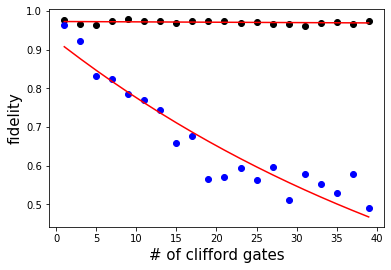

reference_fidelity = 0.9730280809254277
interleaved_fidelity = 0.923748756327117


In [96]:
fit_params1, y_fit1 = fit_function(ms[:20],
                                 average_reference_fidelity_per_m[:20], 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m),
                                 [0.95, 1])

fit_params2, y_fit2 = fit_function(ms[:20],
                                 average_interleaved_fidelity_per_m[:20], 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m),
                                 [0.95, 1])



plt.scatter(ms[:20], average_reference_fidelity_per_m[:20], color='black')
plt.scatter(ms[:20], average_interleaved_fidelity_per_m[:20], color='blue')

plt.plot(ms[:20], y_fit1[:20], color='red')
plt.plot(ms[:20], y_fit2[:20], color='red')

reference_fidelity = fit_params1[1] 
interleaved_fidelity = fit_params2[1]
plt.xlabel("# of clifford gates", fontsize=15)
plt.ylabel("fidelity", fontsize=15)
plt.show()
print('reference_fidelity =', reference_fidelity)
print('interleaved_fidelity =', interleaved_fidelity)

### Base = 'Q', x_gate = 'G', Detuning = 0

In [118]:
ms = np.arange(1,82,2)
experiment_num_per_m = 30

average_reference_fidelity_per_m = np.zeros(len(ms))
reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

average_interleaved_fidelity_per_m = np.zeros(len(ms))
interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [119]:
for n in range(21):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n]= RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'G',n_sequence =n_sequence)

Selected 30 reference sequences with length 1
schdeule 1
Randomly Selected Sequence: [23] / ['zshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 2
Randomly Selected Sequence: [6] / ['ys']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 3 / ['z']
Recovery Gate for Interleaved sequence: 1 / ['x']
********************
schdeule 3
Randomly Selected Sequence: [12] / ['sh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Inter

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 14 / ['ysh']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 29, '1': 995}
fidelity: 0.9716796875
result: {'0': 31, '1': 993}
fidelity: 0.9697265625
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 1012, '1': 12}
fidelity: 0.98828125
result: {'0': 30, '1': 994}
fidelity: 0.970703125
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 26, '1': 998}
fidelity: 0.974609375
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
result: {'0': 27, '1': 997}
fidelity: 0.9736328125
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 1011, '1': 13}
fidelit

Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 17
Randomly Selected Sequence: [23  4 21] / ['zshs', 's', 'xshs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 11 / ['zh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 18
Randomly Selected Sequence: [21  4  9] / ['xshs', 's', 'xh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  re

Job Status: job has successfully run
result: {'0': 129, '1': 895}
fidelity: 0.8740234375
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 980, '1': 44}
fidelity: 0.95703125
result: {'0': 978, '1': 46}
fidelity: 0.955078125
result: {'0': 100, '1': 924}
fidelity: 0.90234375
result: {'0': 29, '1': 995}
fidelity: 0.9716796875
result: {'0': 58, '1': 966}
fidelity: 0.943359375
result: {'0': 104, '1': 920}
fidelity: 0.8984375
result: {'0': 904, '1': 120}
fidelity: 0.8828125
result: {'0': 1000, '1': 24}
fidelity: 0.9765625
result: {'0': 832, '1': 192}
fidelity: 0.8125
result: {'0': 932, '1': 92}
fidelity: 0.91015625
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 878, '1': 146}
fidelity: 0.857421875
result: {'0': 920, '1': 104}
fidelity: 0.8984375
The average reference fidelity is 0.9689127604166666
The average interleaved fidelity is 0.8881184895833333
##################################################

Selected 30 reference sequences with length 5
schdeule 1

Recovery Gate for reference sequence: 5 / ['xs']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 21
Randomly Selected Sequence: [22 18 23 16 18] / ['yshs', 'yhs', 'zshs', 'hs', 'yhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 22
Randomly Selected Sequence: [ 6 17 14 20 13] / ['ys', 'xhs', 'ysh', 'shs', 'xsh']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
*******

Randomly Selected Sequence: [12 20  6 18  4 19 19] / ['sh', 'shs', 'ys', 'yhs', 's', 'zhs', 'zhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 19
Randomly Selected Sequence: [ 6 16 14  9 20 13  9] / ['ys', 'hs', 'ysh', 'xh', 'shs', 'xsh', 'xh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 10 / ['yh']
Recovery Gate for Interleaved sequence: 14 / ['ysh']
********************
schdeule 20
Randomly Selected Sequence: [ 1  6  8 15 23 21  3] / ['x', 'ys', 'h', 'zsh', 'z

Job Status: job has successfully run
result: {'0': 322, '1': 702}
fidelity: 0.314453125
result: {'0': 397, '1': 627}
fidelity: 0.6123046875
result: {'0': 143, '1': 881}
fidelity: 0.8603515625
result: {'0': 792, '1': 232}
fidelity: 0.7734375
result: {'0': 153, '1': 871}
fidelity: 0.8505859375
result: {'0': 322, '1': 702}
fidelity: 0.685546875
result: {'0': 727, '1': 297}
fidelity: 0.7099609375
result: {'0': 608, '1': 416}
fidelity: 0.40625
result: {'0': 513, '1': 511}
fidelity: 0.4990234375
result: {'0': 925, '1': 99}
fidelity: 0.9033203125
result: {'0': 978, '1': 46}
fidelity: 0.955078125
result: {'0': 990, '1': 34}
fidelity: 0.966796875
result: {'0': 83, '1': 941}
fidelity: 0.9189453125
result: {'0': 124, '1': 900}
fidelity: 0.87890625
result: {'0': 66, '1': 958}
fidelity: 0.935546875
The average reference fidelity is 0.9770833333333333
The average interleaved fidelity is 0.746875
##################################################

Selected 30 reference sequences with length 9
schdeul

Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 18
Randomly Selected Sequence: [11  1  0  7 11 11  9 13 14] / ['zh', 'x', 'I', 'zs', 'zh', 'zh', 'xh', 'xsh', 'ysh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 0 / ['I']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 19
Randomly Selected Sequence: [ 6 18 13 21 18 17 10 18  1] / ['ys', 'yhs', 'xsh', 'xshs', 'yhs', 'xhs', 'yh', 'yhs', 'x']
Reference Sequence: recovery gate for 0: [8, 11, 1

Job Status: job has successfully run
result: {'0': 288, '1': 736}
fidelity: 0.71875
result: {'0': 907, '1': 117}
fidelity: 0.8857421875
result: {'0': 513, '1': 511}
fidelity: 0.4990234375
result: {'0': 267, '1': 757}
fidelity: 0.7392578125
result: {'0': 721, '1': 303}
fidelity: 0.7041015625
result: {'0': 629, '1': 395}
fidelity: 0.6142578125
result: {'0': 613, '1': 411}
fidelity: 0.4013671875
result: {'0': 133, '1': 891}
fidelity: 0.8701171875
result: {'0': 561, '1': 463}
fidelity: 0.5478515625
result: {'0': 763, '1': 261}
fidelity: 0.7451171875
result: {'0': 980, '1': 44}
fidelity: 0.95703125
result: {'0': 607, '1': 417}
fidelity: 0.5927734375
result: {'0': 228, '1': 796}
fidelity: 0.77734375
result: {'0': 174, '1': 850}
fidelity: 0.830078125
result: {'0': 394, '1': 630}
fidelity: 0.615234375
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 240, '1': 784}
fidelity: 0.765625
result: {'0': 116, '1': 908}

********************
schdeule 19
Randomly Selected Sequence: [20  5  1  2  5 21 23 14  1  2  4] / ['shs', 'xs', 'x', 'y', 'xs', 'xshs', 'zshs', 'ysh', 'x', 'y', 's']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 19 / ['zhs']
********************
schdeule 20
Randomly Selected Sequence: [ 8 19 15 16  4 23 23 13  3 12 21] / ['h', 'zhs', 'zsh', 'hs', 's', 'zshs', 'zshs', 'xsh', 'z', 'sh', 'xshs']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 6 / ['ys']
Recovery Gate for Interleaved sequence: 5 / ['xs']
*************

Job Status: job has successfully run
result: {'0': 699, '1': 325}
fidelity: 0.6826171875
result: {'0': 965, '1': 59}
fidelity: 0.9423828125
result: {'0': 692, '1': 332}
fidelity: 0.67578125
result: {'0': 329, '1': 695}
fidelity: 0.3212890625
result: {'0': 54, '1': 970}
fidelity: 0.947265625
result: {'0': 622, '1': 402}
fidelity: 0.392578125
result: {'0': 899, '1': 125}
fidelity: 0.8779296875
result: {'0': 632, '1': 392}
fidelity: 0.3828125
result: {'0': 470, '1': 554}
fidelity: 0.541015625
result: {'0': 895, '1': 129}
fidelity: 0.8740234375
result: {'0': 861, '1': 163}
fidelity: 0.8408203125
result: {'0': 187, '1': 837}
fidelity: 0.1826171875
result: {'0': 100, '1': 924}
fidelity: 0.90234375
result: {'0': 81, '1': 943}
fidelity: 0.9208984375
result: {'0': 769, '1': 255}
fidelity: 0.7509765625
The average reference fidelity is 0.976953125
The average interleaved fidelity is 0.6675455729166667
##################################################

Selected 30 reference sequences with length

********************
schdeule 15
Randomly Selected Sequence: [13 13 17  4  1  9 17  4 14  2 21  5  9] / ['xsh', 'xsh', 'xhs', 's', 'x', 'xh', 'xhs', 's', 'ysh', 'y', 'xshs', 'xs', 'xh']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 16
Randomly Selected Sequence: [ 6 12  5  6  0 15  8 16 10  0 12 18 16] / ['ys', 'sh', 'xs', 'ys', 'I', 'zsh', 'h', 'hs', 'yh', 'I', 'sh', 'yhs', 'hs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for In

********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 1008, '1': 16}
fidelity: 0.984375
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 31, '1': 993}
fidelity: 0.9697265625
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 31, '1': 993}
fidelity: 0.9697265625
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 1010, '1': 14}
fidelity: 0.986328125
result: {'0': 1014, '1': 10}
fidelity: 0.990234375
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 36, '1': 988}
fidelity: 0.96484375
result: {'0': 36, '1': 988}
fidelity: 0.96484375
result: {'0': 1007, '1': 17}
fidelity: 0.9833984375
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result:

Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 0 / ['I']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 11
Randomly Selected Sequence: [22 12 15 10 14 10 14  7 22 22 10 17 19 11 23] / ['yshs', 'sh', 'zsh', 'yh', 'ysh', 'yh', 'ysh', 'zs', 'yshs', 'yshs', 'yh', 'xhs', 'zhs', 'zh', 'zshs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 12
Randomly Selected Sequence: [13  9 23 18 12 19  3  3 17  8 13 13 16  8  4] / ['xsh', 'xh', 'zshs', 'yhs', 'sh', 'zhs', 'z', 'z', 'xhs', 'h', 'xsh', 'xsh', 'hs', 'h', 's']
Reference Sequence: recovery gat

schdeule 29
Randomly Selected Sequence: [ 9  5 18  0 19  2 10  2 16  6 11 15 12  6 19] / ['xh', 'xs', 'yhs', 'I', 'zhs', 'y', 'yh', 'y', 'hs', 'ys', 'zh', 'zsh', 'sh', 'ys', 'zhs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 30
Randomly Selected Sequence: [ 2 12 16 20 22 22 18 17 12  0  7 15  3  6  3] / ['y', 'sh', 'hs', 'shs', 'yshs', 'yshs', 'yhs', 'xhs', 'sh', 'I', 'zs', 'zsh', 'z', 'ys', 'z']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recover

********************
schdeule 14
Randomly Selected Sequence: [ 5 23 12  6  9  0 14  5  6 18 10  9  8 10 17 16  4] / ['xs', 'zshs', 'sh', 'ys', 'xh', 'I', 'ysh', 'xs', 'ys', 'yhs', 'yh', 'xh', 'h', 'yh', 'xhs', 'hs', 's']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 17 / ['xhs']
Recovery Gate for Interleaved sequence: 20 / ['shs']
********************
schdeule 15
Randomly Selected Sequence: [11  9  2  0 20 18 22  0  9 13 19  0 21 22 17 17 13] / ['zh', 'xh', 'y', 'I', 'shs', 'yhs', 'yshs', 'I', 'xh', 'xsh', 'zhs', 'I', 'xshs', 'yshs', 'xhs', 'xhs', 'xsh']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
R

Job Status: job has successfully run
result: {'0': 49, '1': 975}
fidelity: 0.9521484375
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 998, '1': 26}
fidelity: 0.974609375
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 36, '1': 988}
fidelity: 0.96484375
result: {'0': 981, '1': 43}
fidelity: 0.9580078125
result: {'0': 28, '1': 996}
fidelity: 0.97265625
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 993, '1': 31}
fidelity: 0.9697265625
result: {'0': 991, '1': 33}
fidelity: 0.9677734375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 993, '1': 31}
fidelity: 

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 12 / ['sh']
********************
schdeule 16
Randomly Selected Sequence: [ 3 15 20 18  3 21 10  0  3  1  2 19 10  1  9  7 11 20 21] / ['z', 'zsh', 'shs', 'yhs', 'z', 'xshs', 'yh', 'I', 'z', 'x', 'y', 'zhs', 'yh', 'x', 'xh', 'zs', 'zh', 'shs', 'xshs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 17
Randomly Selected Sequence: [14  5  1  7 16  0 15 15  3  6 18 1

********************
schdeule 30
Randomly Selected Sequence: [12 21  5 16 15  7 22 16 23 23 14  4  3  0  0 19 15 20 15] / ['sh', 'xshs', 'xs', 'hs', 'zsh', 'zs', 'yshs', 'hs', 'zshs', 'zshs', 'ysh', 's', 'z', 'I', 'I', 'zhs', 'zsh', 'shs', 'zsh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 1011, '1': 13}
fidelity: 0.9873046875
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 1004, '1': 20}
fidelity: 0.98046875
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 1009, '1': 15}
fidelity: 0.9853515625
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
resu

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 20 / ['shs']
Recovery Gate for Interleaved sequence: 21 / ['xshs']
********************
schdeule 16
Randomly Selected Sequence: [19 23 19 12  5 14  5  7 20  5  8 17 17 12  7 16 22  3  6  3  8] / ['zhs', 'zshs', 'zhs', 'sh', 'xs', 'ysh', 'xs', 'zs', 'shs', 'xs', 'h', 'xhs', 'xhs', 'sh', 'zs', 'hs', 'yshs', 'z', 'ys', 'z', 'h']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 20 / ['shs']
********************
schdeule 17
Randomly Selected Sequence: [22 15 

********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 987, '1': 37}
fidelity: 0.9638671875
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 994, '1': 30}
fidelity: 0.970703125
result: {'0': 997, '1': 27}
fidelity: 0.9736328125
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 989, '1': 35}
fidelity: 0.9658203125
result: {'0': 989, '1': 35}
fidelity: 0.9658203125
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 996, '1': 28}
fidelity: 0.97265625
result: {'0': 40, '1': 984}
fidelity: 0.9609375
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 985, '1': 39}
fidelity: 0.9619140625
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
r

Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 1 / ['x']
********************
schdeule 15
Randomly Selected Sequence: [23  3 20  3  8  9  2  7 20 19 14  8  5 15  1 17 13 18 17  3 17 15 22] / ['zshs', 'z', 'shs', 'z', 'h', 'xh', 'y', 'zs', 'shs', 'zhs', 'ysh', 'h', 'xs', 'zsh', 'x', 'xhs', 'xsh', 'yhs', 'xhs', 'z', 'xhs', 'zsh', 'yshs']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
schdeule 16
Randomly Selected Sequence: [22  2  7  7 18  4 20  1 13 19 2

Job Status: job has successfully run
result: {'0': 53, '1': 971}
fidelity: 0.9482421875
result: {'0': 1006, '1': 18}
fidelity: 0.982421875
result: {'0': 24, '1': 1000}
fidelity: 0.9765625
result: {'0': 27, '1': 997}
fidelity: 0.9736328125
result: {'0': 992, '1': 32}
fidelity: 0.96875
result: {'0': 37, '1': 987}
fidelity: 0.9638671875
result: {'0': 48, '1': 976}
fidelity: 0.953125
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 34, '1': 990}
fidelity: 0.966796875
result: {'0': 1003, '1': 21}
fidelity: 0.9794921875
result: {'0': 1001, '1': 23}
fidelity: 0.9775390625
result: {'0': 33, '1': 991}
fidelity: 0.9677734375
result: {'0': 42, '1': 982}
fidelity: 0.958984375
result: {'0': 46, '1': 978}
fidelity: 0.955078125
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
result: {'0': 995, '1': 29}
fidelity: 0.9716796875
result: {'0': 27, '1': 997}
fidelity: 0.973

********************
schdeule 15
Randomly Selected Sequence: [14 23 19  2 22 23  5  7  4  1 18 15 10  3  9  2 14  6 14 11 18  1 22 18
  3] / ['ysh', 'zshs', 'zhs', 'y', 'yshs', 'zshs', 'xs', 'zs', 's', 'x', 'yhs', 'zsh', 'yh', 'z', 'xh', 'y', 'ysh', 'ys', 'ysh', 'zh', 'yhs', 'x', 'yshs', 'yhs', 'z']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 23 / ['zshs']
Recovery Gate for Interleaved sequence: 22 / ['yshs']
********************
schdeule 16
Randomly Selected Sequence: [10 15 19 13 15 16  9  8 16 16  1  2 11 14  4  4  7  5 15  2 21 11 23 19
  6] / ['yh', 'zsh', 'zhs', 'xsh', 'zsh', 'hs', 'xh', 'h', 'hs', 'hs', 'x', 'y', 'zh', 'ysh', 's', 's', 'zs', 'xs', 'zsh', 'y', 'xshs', 'zh', 'zshs', 'zhs', 'ys']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  reco

Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 9 / ['xh']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
result: {'0': 999, '1': 25}
fidelity: 0.9755859375
result: {'0': 39, '1': 985}
fidelity: 0.9619140625
result: {'0': 38, '1': 986}
fidelity: 0.962890625
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 32, '1': 992}
fidelity: 0.96875
result: {'0': 31, '1': 993}
fidelity: 0.9697265625
result: {'0': 41, '1': 983}
fidelity: 0.9599609375
result: {'0': 44, '1': 980}
fidelity: 0.95703125
result: {'0': 35, '1': 989}
fidelity: 0.9658203125
result: {'0': 24, '1': 1000}
fidelity: 0.9765625
result: {'0': 35, '1': 989}
fidelity: 0.9658

KeyboardInterrupt: 

In [124]:
average_reference_fidelity_per_m[11]

0.9652994791666667

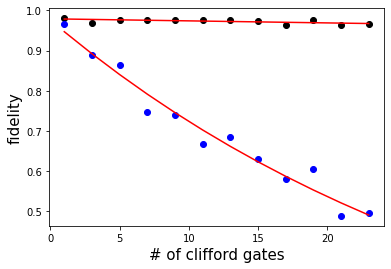

reference_fidelity = 0.9997387264461016
interleaved_fidelity = 0.9852889679524652


In [132]:
fit_params1, y_fit1 = fit_function(ms[:12],
                                 average_reference_fidelity_per_m[:12], 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m),
                                 [0.95, 1])

fit_params2, y_fit2 = fit_function(ms[:12],
                                 average_interleaved_fidelity_per_m[:12], 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m),
                                 [0.95, 1])



plt.scatter(ms[:12], average_reference_fidelity_per_m[:12], color='black')
plt.scatter(ms[:12], average_interleaved_fidelity_per_m[:12], color='blue')

plt.plot(ms[:12], y_fit1[:12], color='red')
plt.plot(ms[:12], y_fit2[:12], color='red')

reference_fidelity = fit_params1[0] 
interleaved_fidelity = fit_params2[0]
plt.xlabel("# of clifford gates", fontsize=15)
plt.ylabel("fidelity", fontsize=15)
plt.show()
print('reference_fidelity =', reference_fidelity)
print('interleaved_fidelity =', interleaved_fidelity)

In [134]:
np.savetxt("m_Qiskit_Gaussian_detuning=0",ms[:12])
np.savetxt("reference_Qiskit_Gaussian_detuning=0",average_reference_fidelity_per_m[:12])
np.savetxt("interleaved_Qiskit_Gaussian_detuning=0",average_interleaved_fidelity_per_m[:12])

### base = Q, x_gate = P, detuning = 0

In [61]:
ms = np.arange(1,82,2)
experiment_num_per_m = 30

average_reference_fidelity_per_m = np.zeros(len(ms))
reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

average_interleaved_fidelity_per_m = np.zeros(len(ms))
interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [83]:
n_sequence = 15
for n in range(21):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n]= RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'P',n_sequence =n_sequence, print_schedule= False, print_result = False)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.96220703125
The average interleaved fidelity is 0.9583333333333334
##################################################

Selected 30 reference sequences with length 3
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J